In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
%matplotlib inline
from collections import Counter

import peakutils

from numpy.fft import fft, rfft, rfftfreq, irfft
import seaborn as sns

import pickle

from ipywidgets import FloatProgress
from IPython.display import display

from scipy import signal 

from os import listdir
from os.path import isfile, join

FD = 2000 # 2кГц - частота дискретизации сигнала

## План работы

Матрица качества классификации (AUC, несколько алгоритмов) 
Для каждой пары болезней: 
Основа - 2x2: обучение-тест на (р-р, р-ч, ч-р, ч-ч)
Таких матриц - по числу алгоритмов (или совместить, например, три алгоритма в одной ячейке, разделив по цветам)

## Датасет Влады

INFO-файл Влады

In [2]:
data_file = pd.read_csv("../Supervised KDMs/info.txt", names=None, header=None)
data = pd.DataFrame(np.array(data_file.iloc[:, 6:]), columns=range(1200))
for i in range(4):
    data.loc[data_file[i+2] == 1,"target"] = i

INFO-файл Кирилла

In [3]:
data_file = pd.read_csv("../Supervised KDMs/info-scatter.txt", names=None, header=None)
kirill_data = pd.DataFrame(np.array(data_file.iloc[:, 6:]), columns=range(1200))
for i in range(4):
    kirill_data.loc[data_file[i+2] == 1,"target"] = i

Создание списков файлов с болезнями - files_per_illness

In [4]:
files_per_illness = 100
illness_file_indexes = np.zeros((4, files_per_illness))
for i in range(4):
    illness_file_indexes[i, :] = data[data["target"]==i].index[:files_per_illness]

In [26]:
for i in range(4):
    print illness_file_indexes[i, 20:60]

[ 311.  312.  313.  314.  315.  316.  317.  318.  319.  320.  321.  322.
  323.  324.  325.  326.  327.  328.  329.  330.  331.  332.  333.  334.
  335.  336.  337.  338.  339.  340.  341.  342.  343.  344.  345.  346.
  347.  348.  349.  350.]
[ 110.  111.  112.  113.  114.  115.  116.  117.  118.  119.  120.  121.
  122.  123.  124.  125.  126.  127.  128.  129.  130.  131.  132.  133.
  134.  135.  136.  137.  138.  139.  140.  141.  142.  143.  144.  145.
  146.  147.  148.  149.]
[ 52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.
  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.
  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.]
[  23.   24.   25.   26.   27.   28.   29.   30.   31.   32.  196.  197.
  198.  199.  200.  201.  202.  203.  204.  205.  206.  207.  208.  209.
  210.  211.  212.  213.  214.  215.  216.  217.  218.  219.  220.  221.
  222.  223.  224.  225.]


Чтение КДМ-файлов, рассортированных по папкам

In [27]:
pb = FloatProgress(min=0, max=3)
display(pb)
kdms = []
for i in range(4):
    mypath = "../Supervised KDMs/" + str(i) + "/"
    file_names = [mypath+f for f in listdir(mypath) if isfile(join(mypath, f))]
    pb2 = FloatProgress(min=0, max=len(file_names)) 
    display(pb2)
    kdms1 = []
    for f in file_names:
        #print f
        kdms1.append(np.array(readSignalFromFile(f).sig1))
        pb2.value+=1
    kdms.append(kdms1)
    pb.value = i

Получение списка имен файлов

In [3]:
kdms_name = []
for i in range(4):
    mypath = "../Supervised KDMs/" + str(i) + "/"
    file_names = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    kdms_name.append(file_names)

Расчет интервалов и амплитуд

In [30]:
ai_all = []
for i, files in enumerate(kdms):
    mid = []
    pb2 = FloatProgress(min=0, max=len(files)) 
    display(pb2)
    for j, f in enumerate(files):
        mn, mx = getExtremaSuperFast(f)
        #print("({},{}): {} - {}".format(i, j, np.abs(mn[0] - mx[0]), np.abs(mn[-1] - mx[-1])))
        pb2.value+=1
        
        intervals = []
        for a, b in zip(mn[:-1], mn[1:]):
            intervals.append(b-a)
            
        amplitudes = []
        for a, b in zip(mn, mx):
            amplitudes.append(f[b]-f[a])
            
        mid.append((intervals, amplitudes))
    ai_all.append(mid)

(0,0): 49 - 41
(0,1): 47 - 40
(0,2): 43 - 1855
(0,3): 46 - 52
(0,4): 51 - 47
(0,5): 44 - 51
(0,6): 44 - 36
(0,7): 27 - 60
(0,8): 180 - 75
(0,9): 52 - 55
(0,10): 43 - 64
(0,11): 59 - 59
(0,12): 47 - 40
(0,13): 25 - 57
(0,14): 139 - 64
(0,15): 58 - 59
(0,16): 77 - 78
(0,17): 56 - 130
(0,18): 97 - 142
(0,19): 49 - 52
(0,20): 62 - 57
(0,21): 68 - 65
(0,22): 69 - 66
(0,23): 32 - 60
(0,24): 65 - 56
(0,25): 54 - 56
(0,26): 72 - 92
(0,27): 51 - 88
(0,28): 31 - 58
(0,29): 30 - 67
(0,30): 61 - 59
(0,31): 234 - 120
(0,32): 126 - 65
(0,33): 63 - 66
(0,34): 44 - 44
(0,35): 65 - 103
(1,0): 57 - 65
(1,1): 43 - 63
(1,2): 60 - 60
(1,3): 64 - 61
(1,4): 48 - 48
(1,5): 136 - 61
(1,6): 47 - 49
(1,7): 87 - 61
(1,8): 88 - 1640
(1,9): 70 - 59
(1,10): 56 - 40
(1,11): 35 - 44
(1,12): 44 - 42
(1,13): 178 - 1249
(1,14): 55 - 45
(1,15): 62 - 62
(1,16): 71 - 59
(1,17): 167 - 68
(1,18): 68 - 60
(1,19): 54 - 28
(1,20): 143 - 55
(1,21): 37 - 54
(1,22): 43 - 1075
(1,23): 58 - 47
(1,24): 38 - 44
(1,25): 74 - 54
(1,26): 

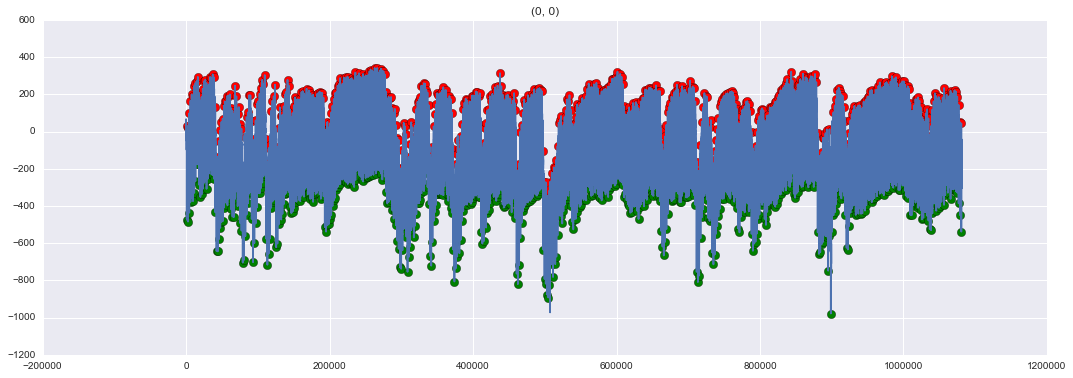

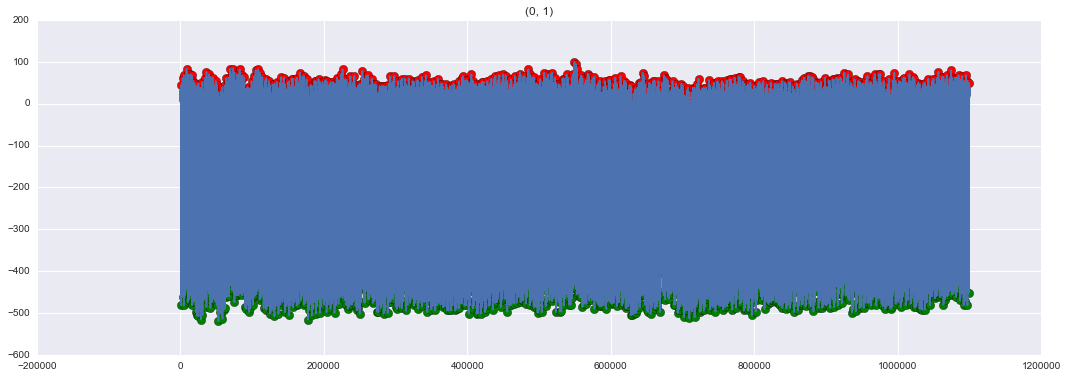

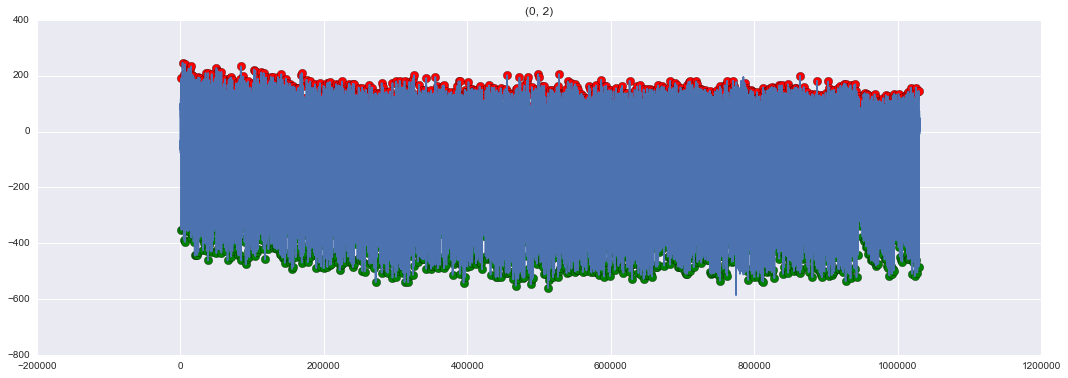

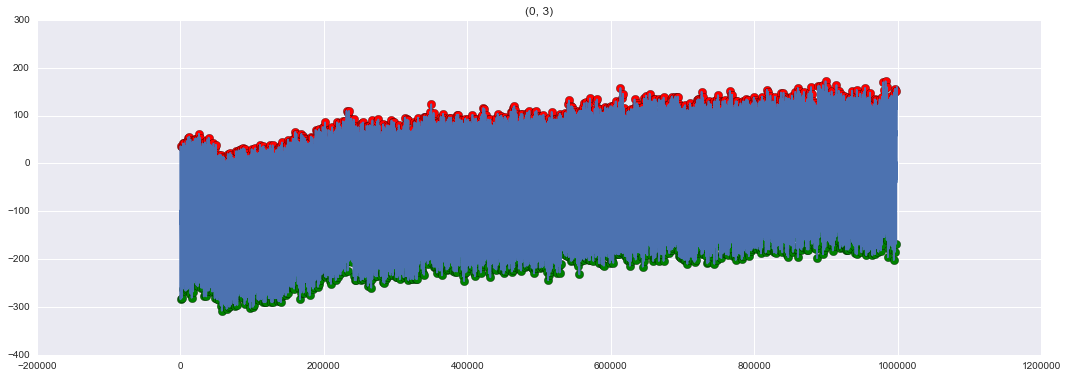

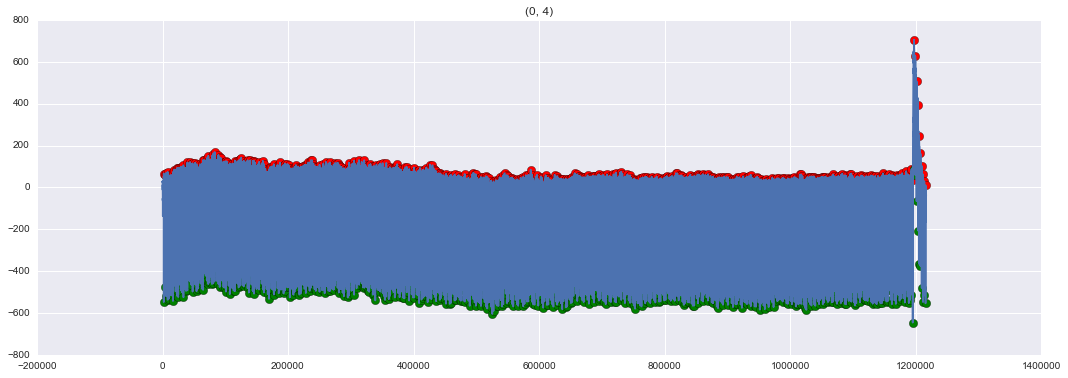

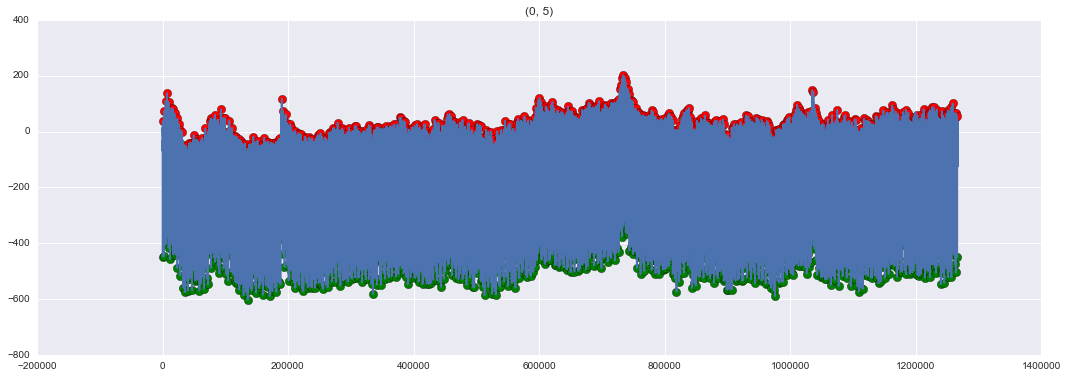

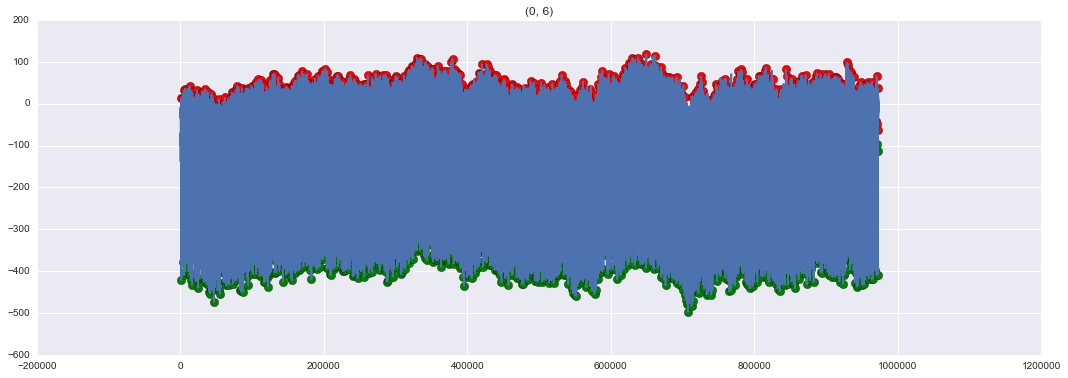

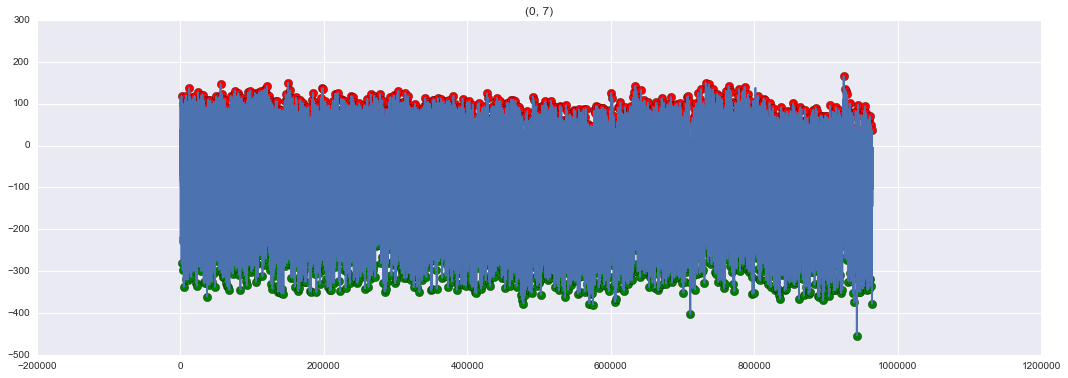

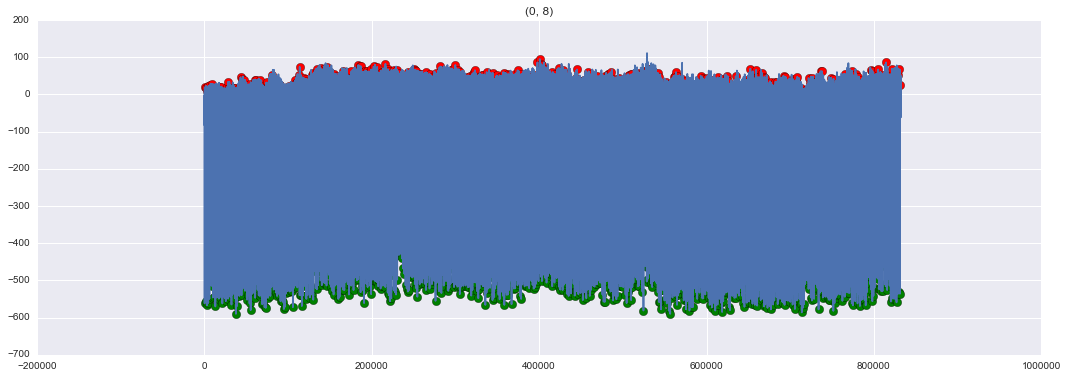

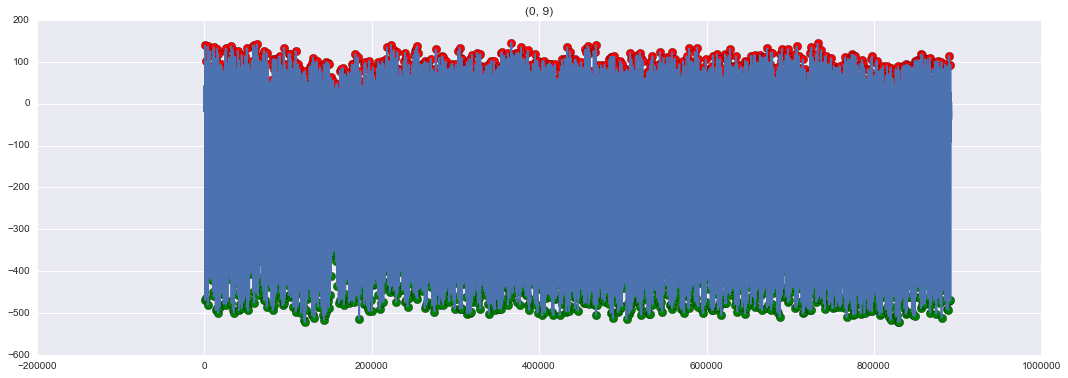

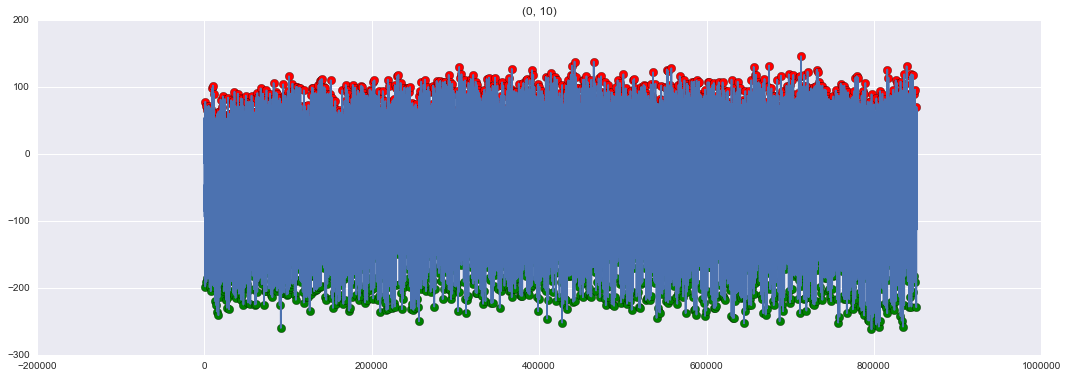

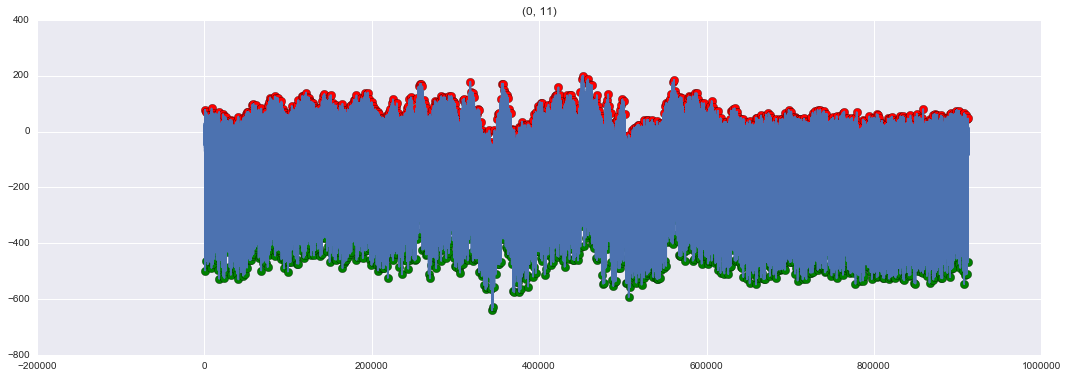

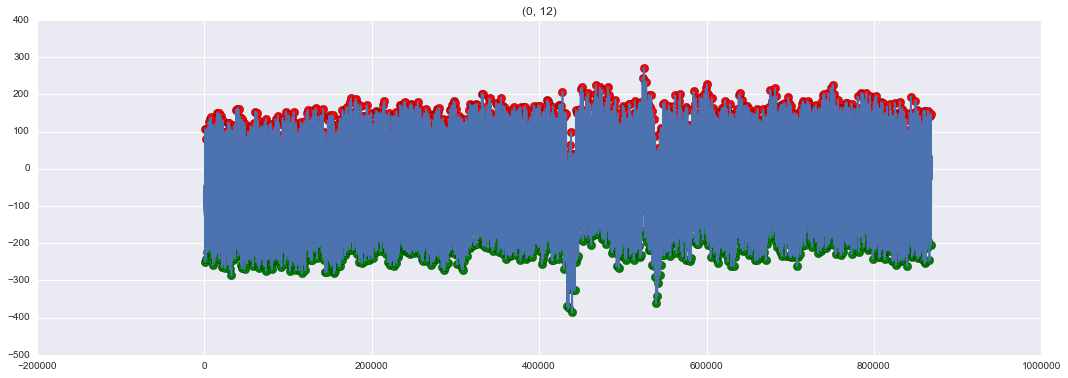

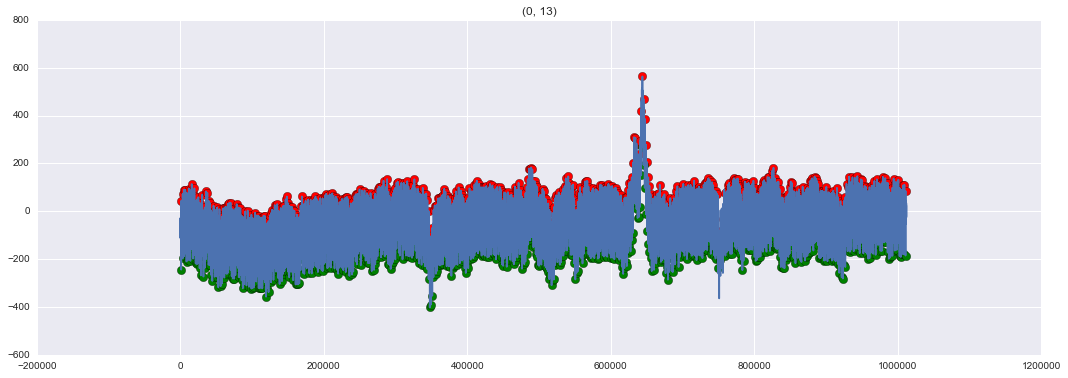

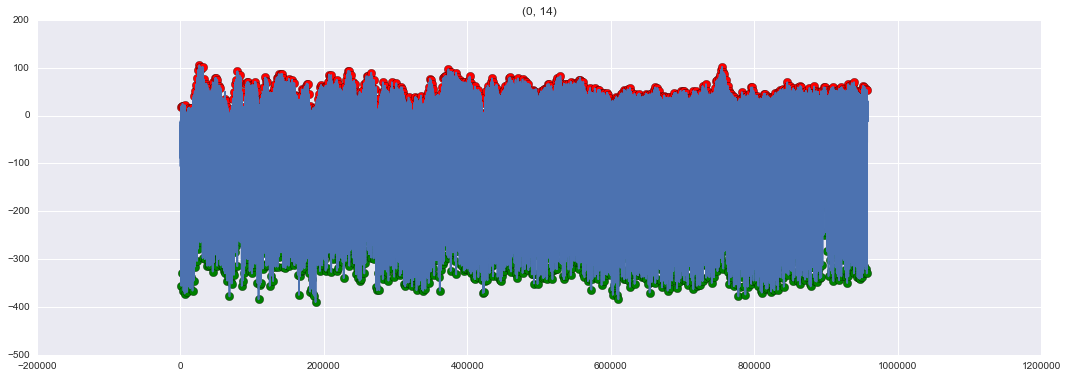

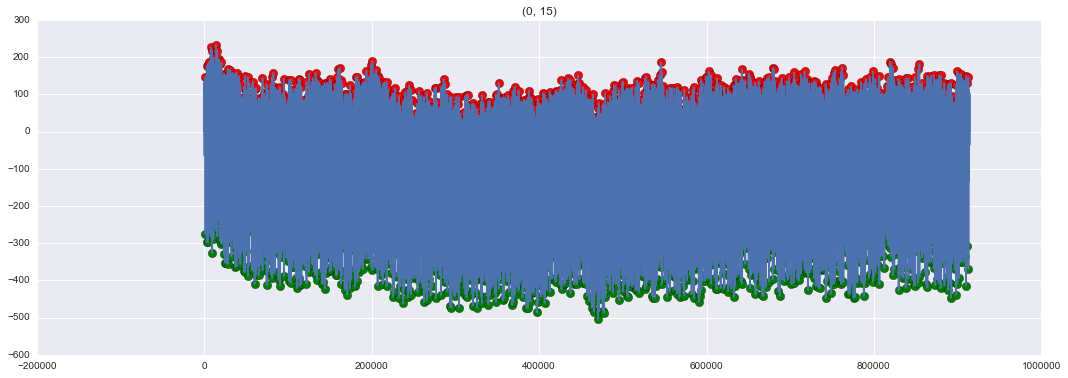

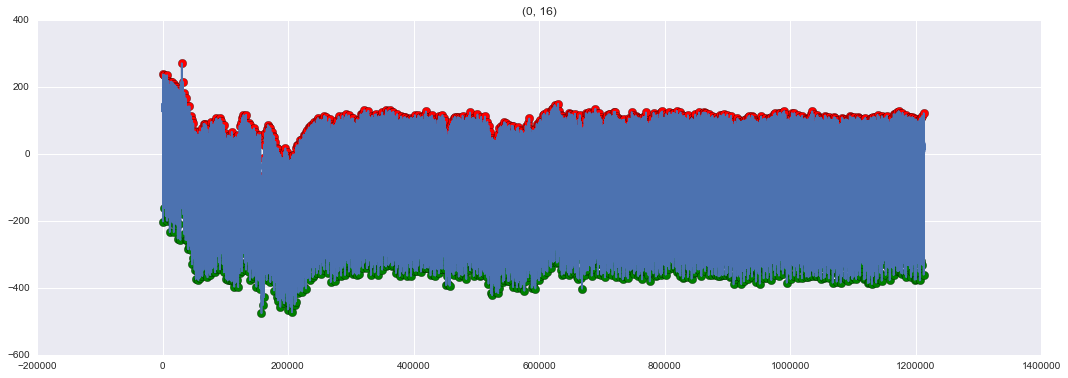

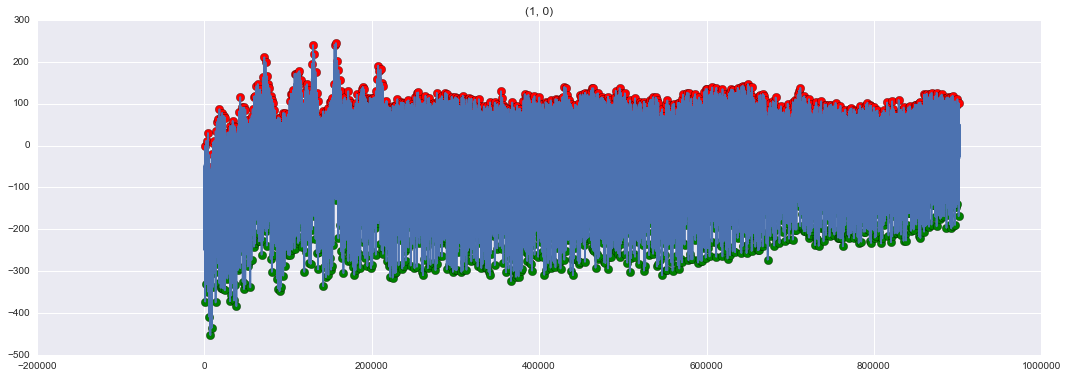

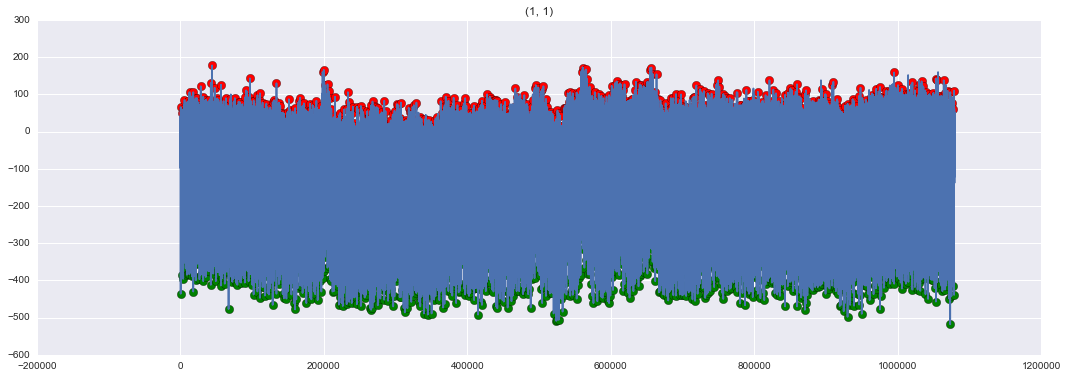

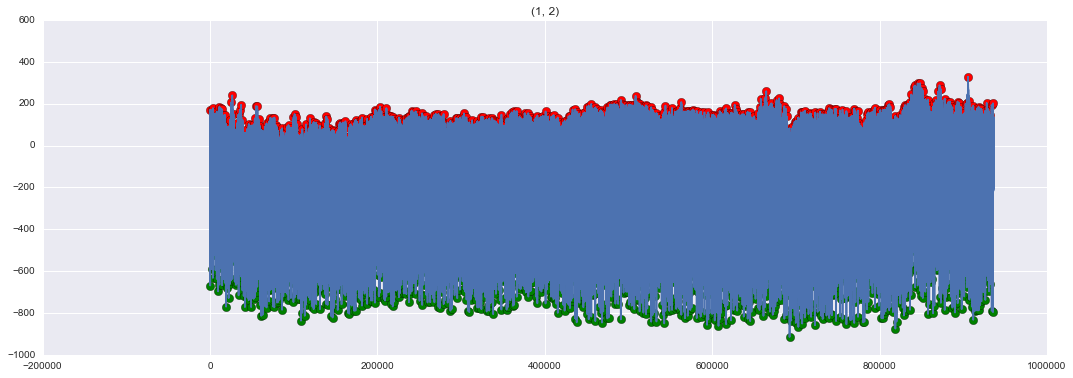

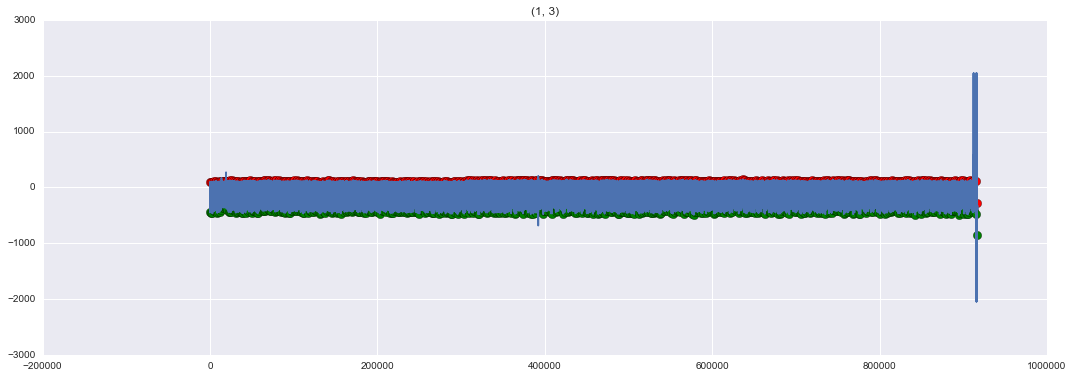

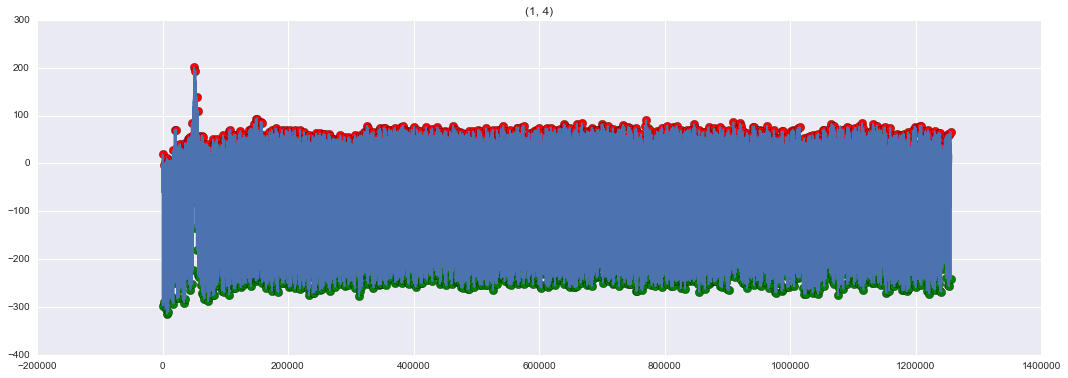

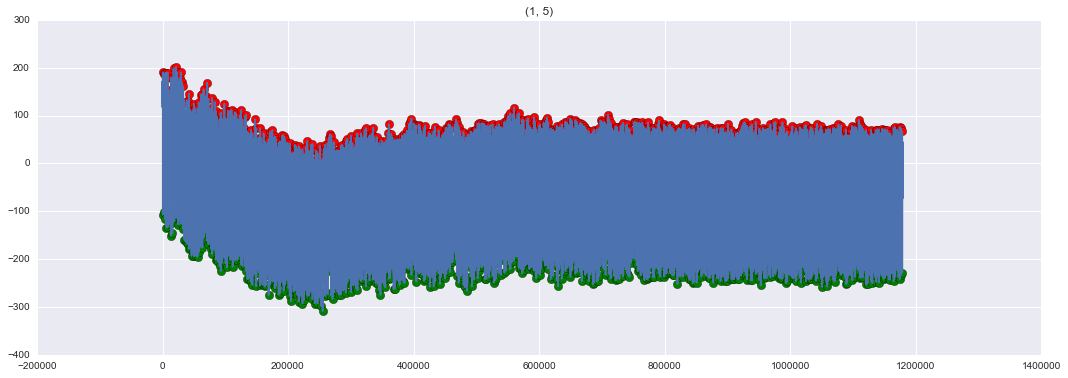

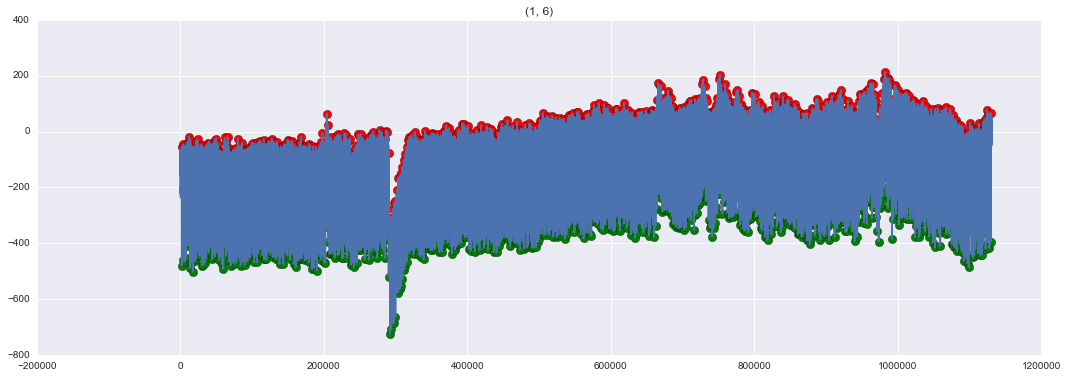

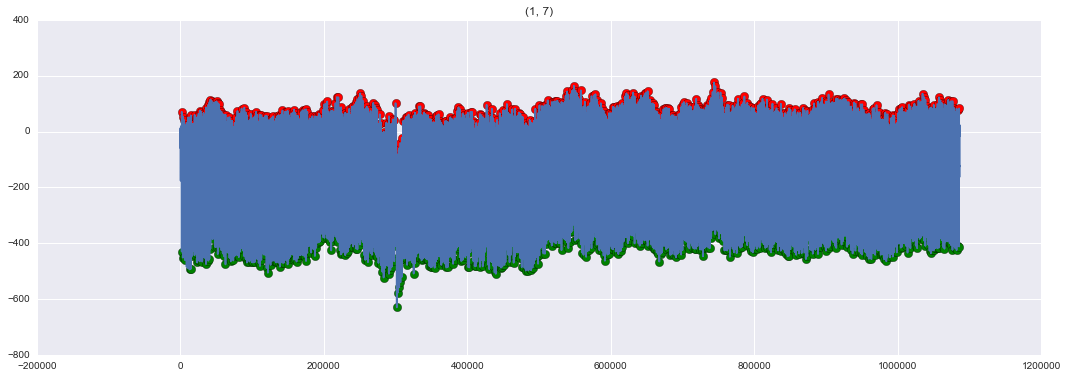

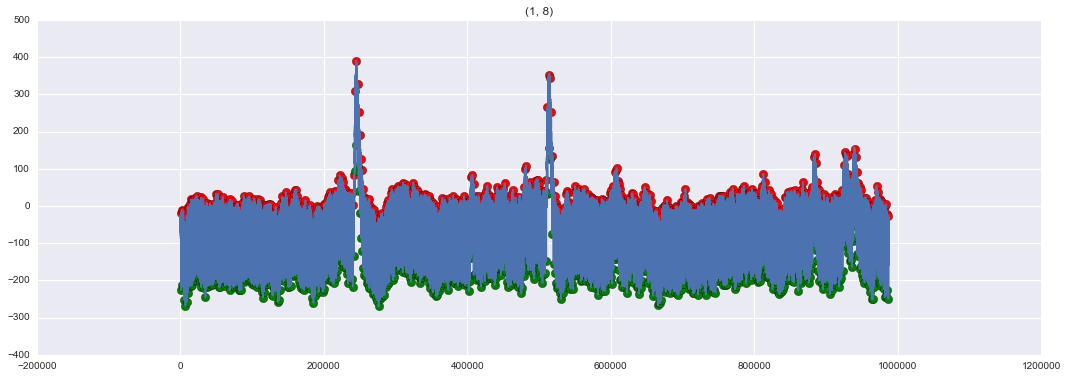

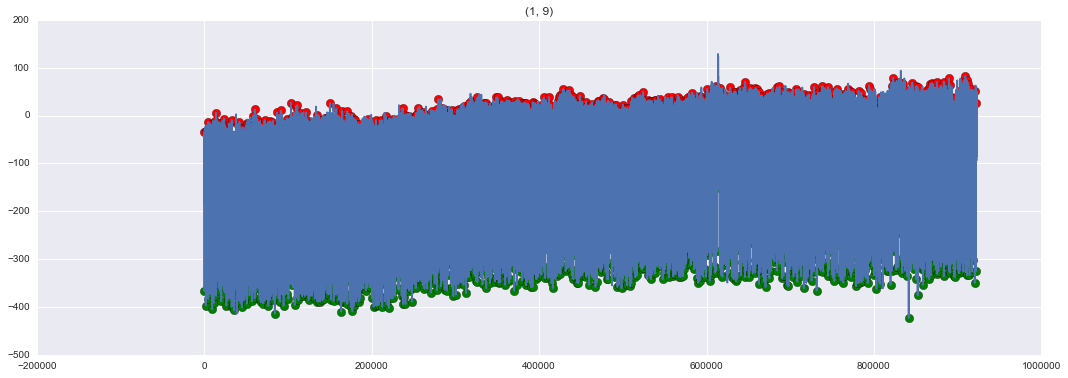

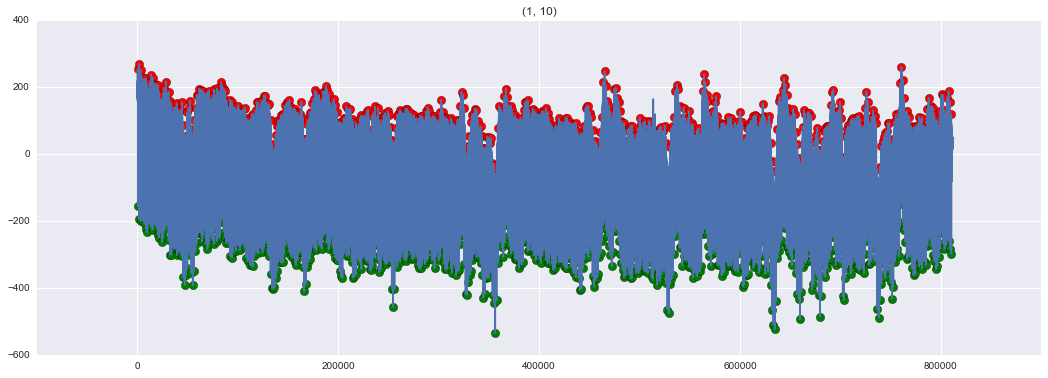

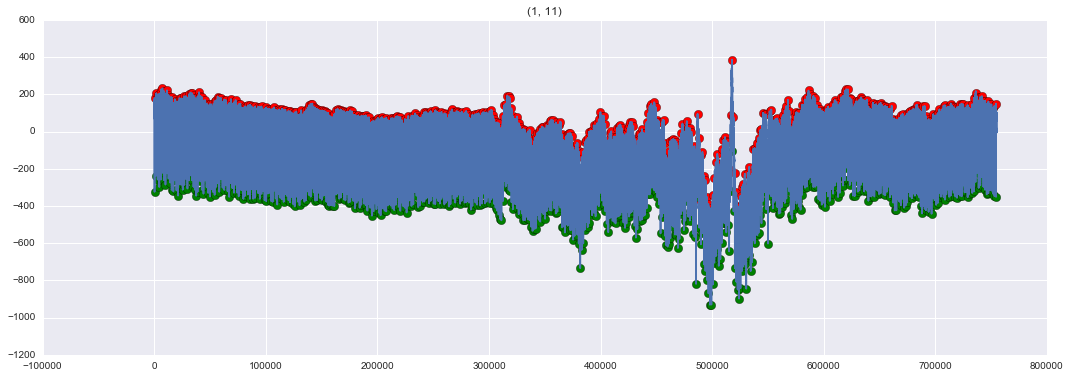

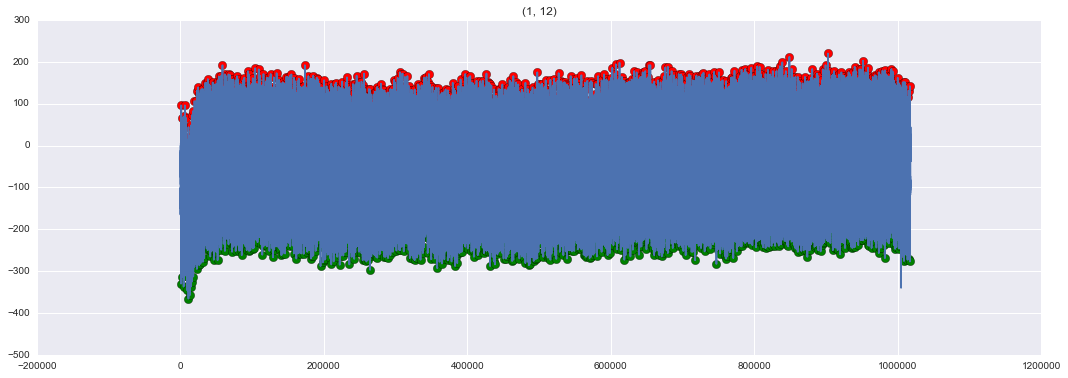

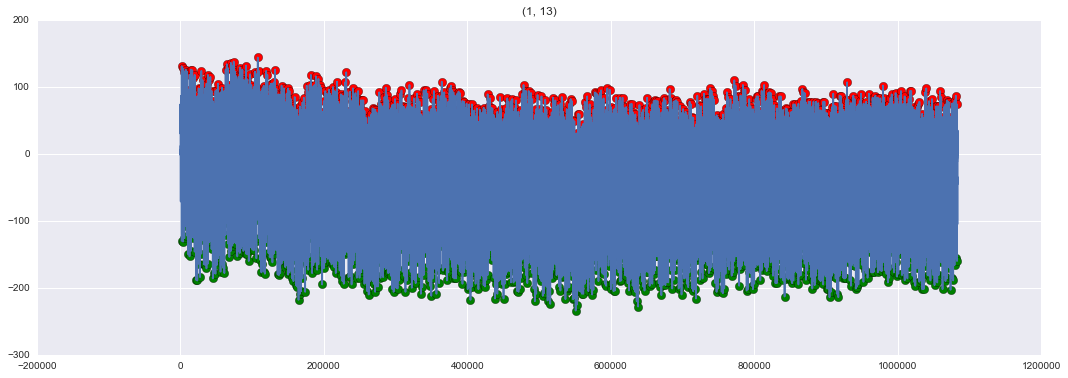

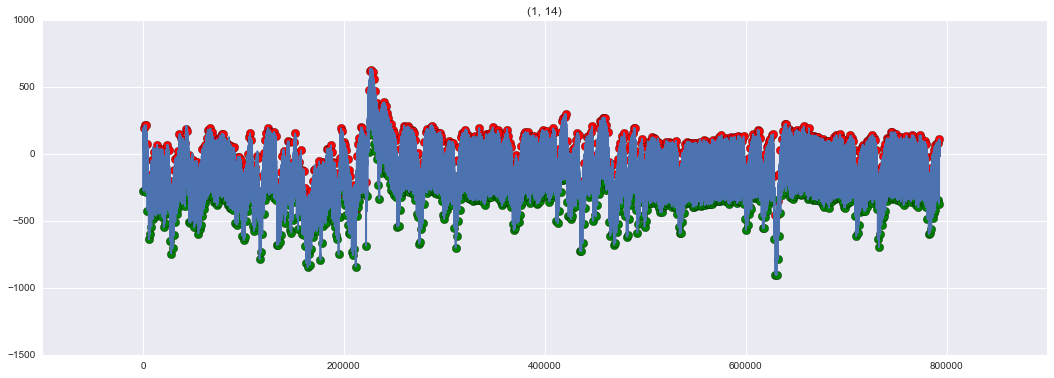

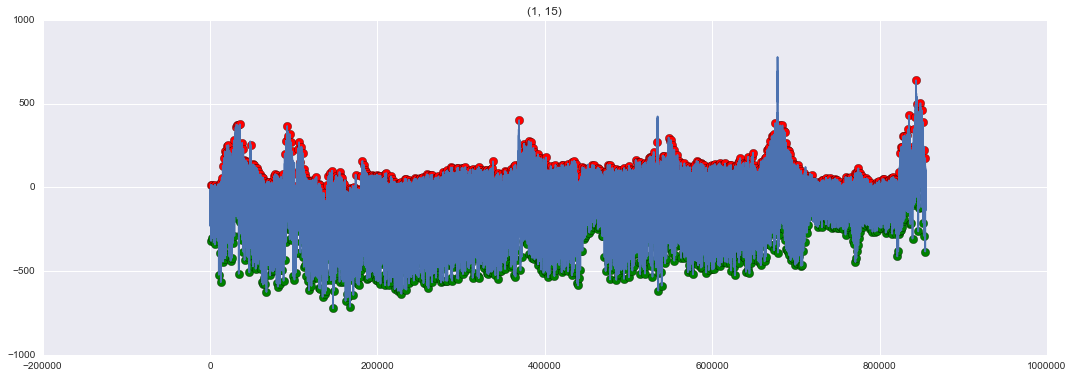

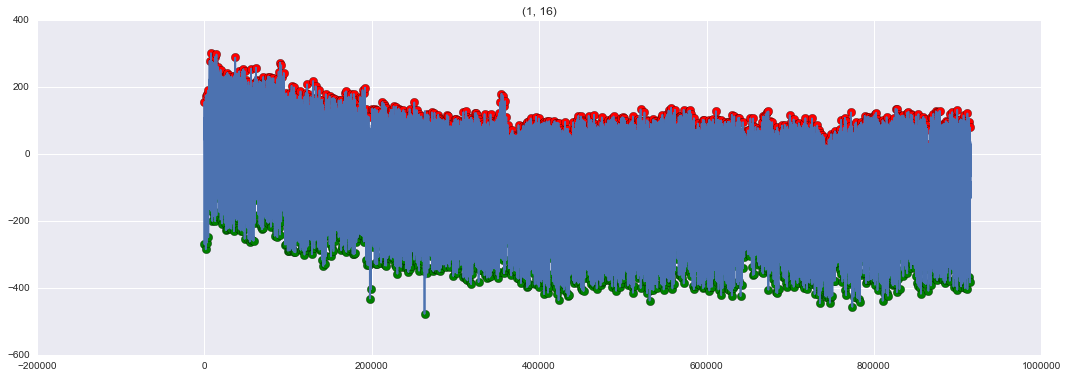

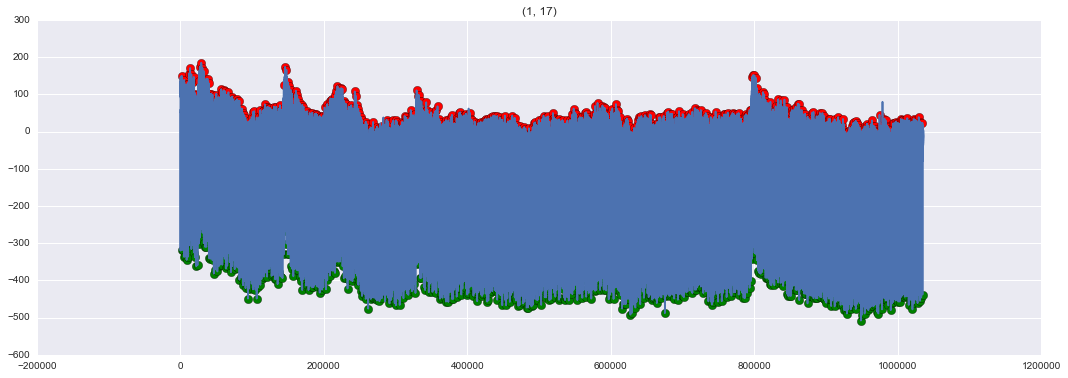

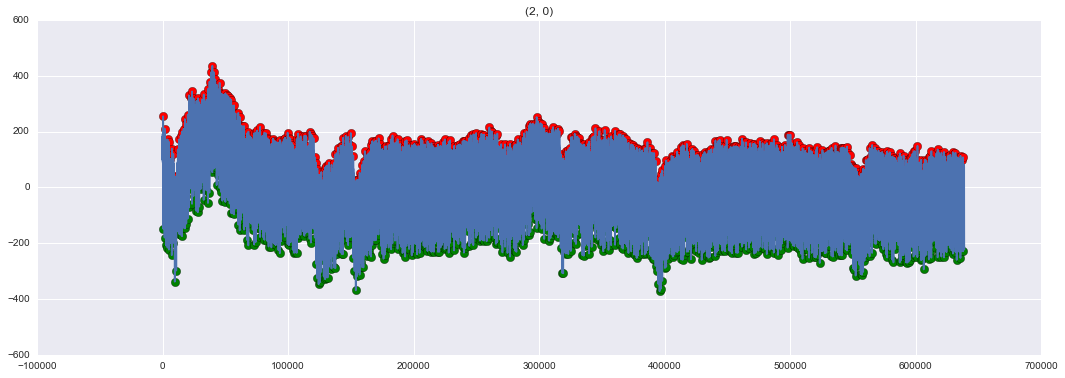

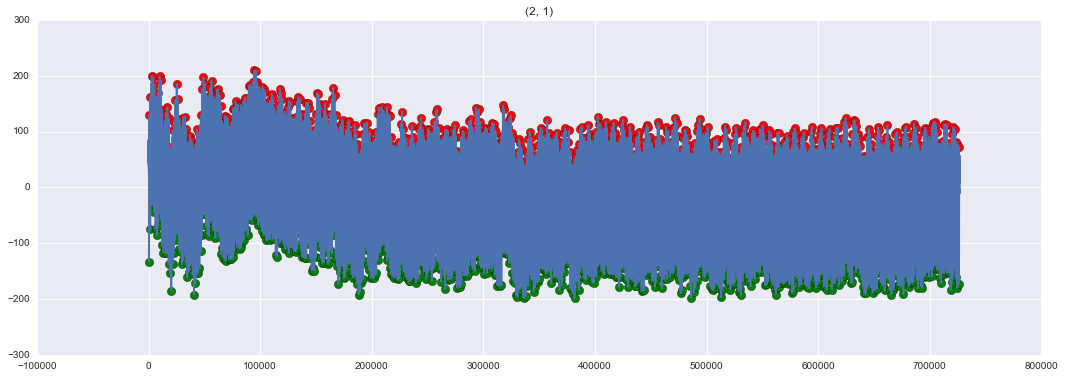

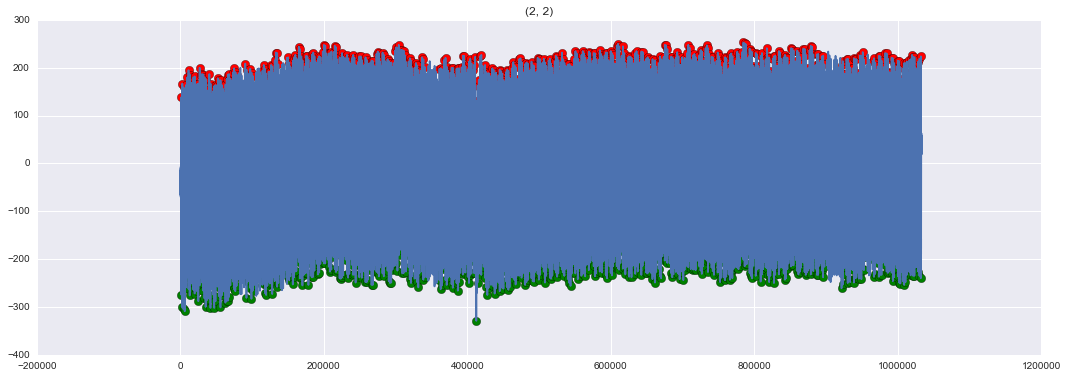

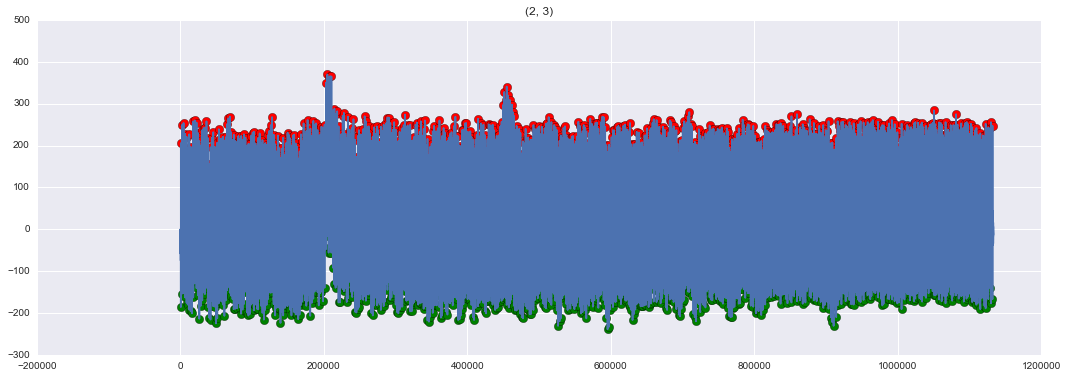

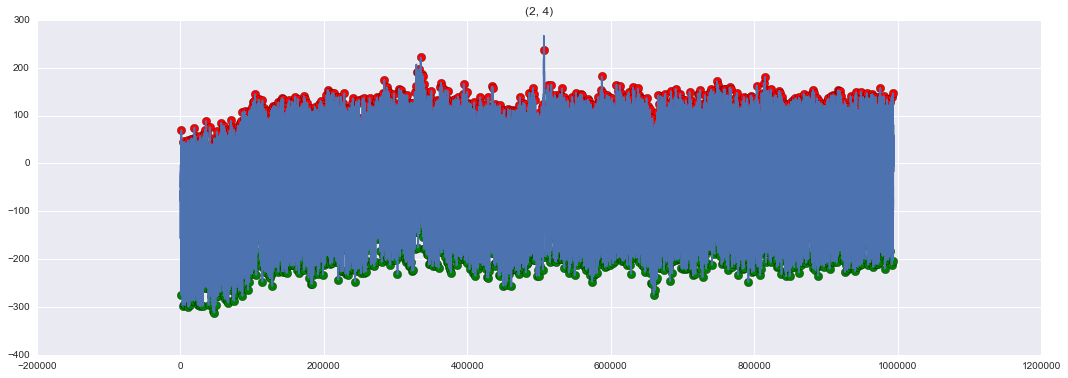

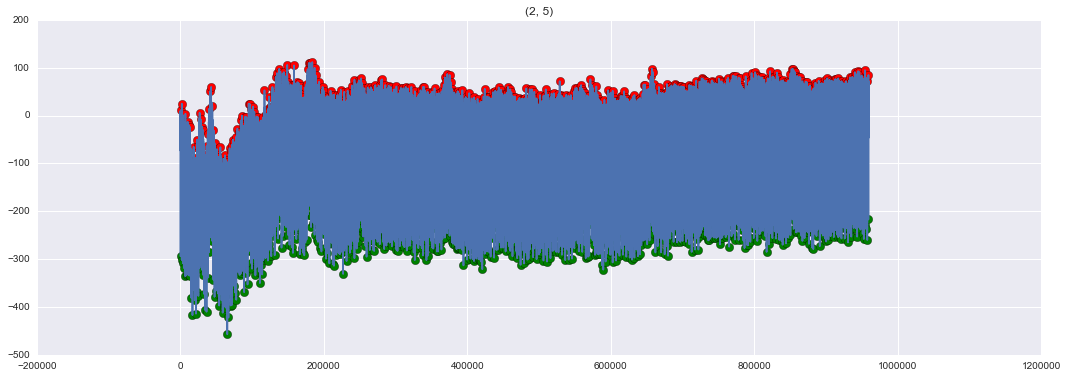

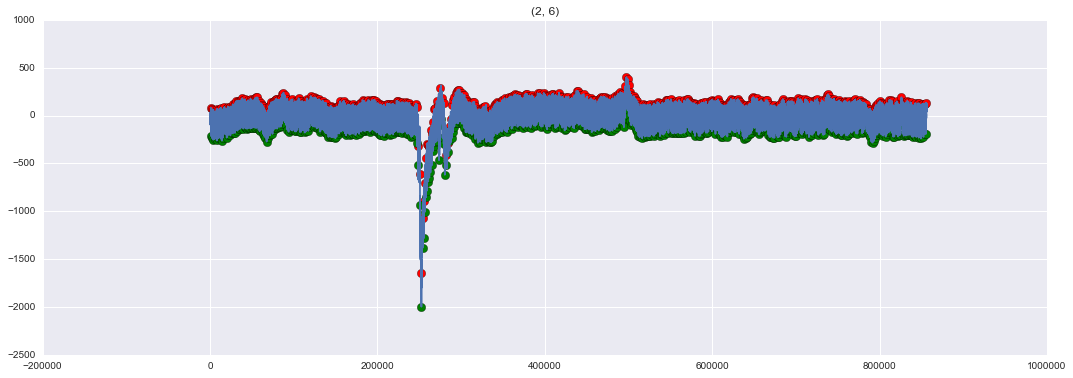

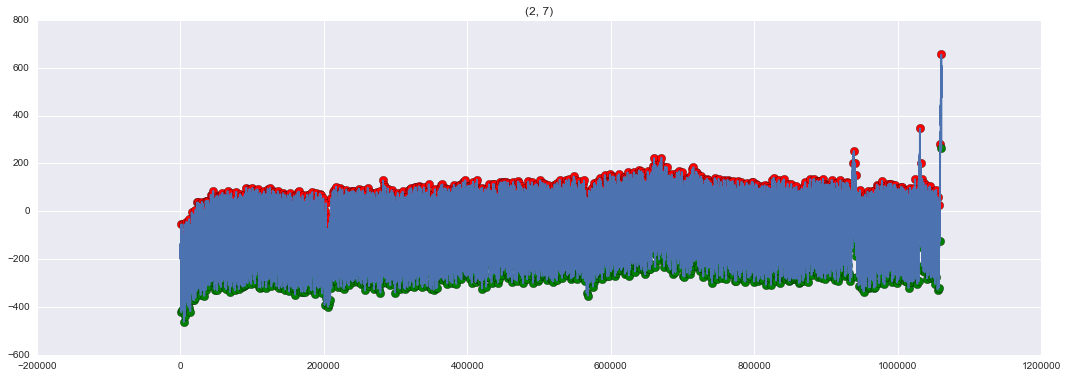

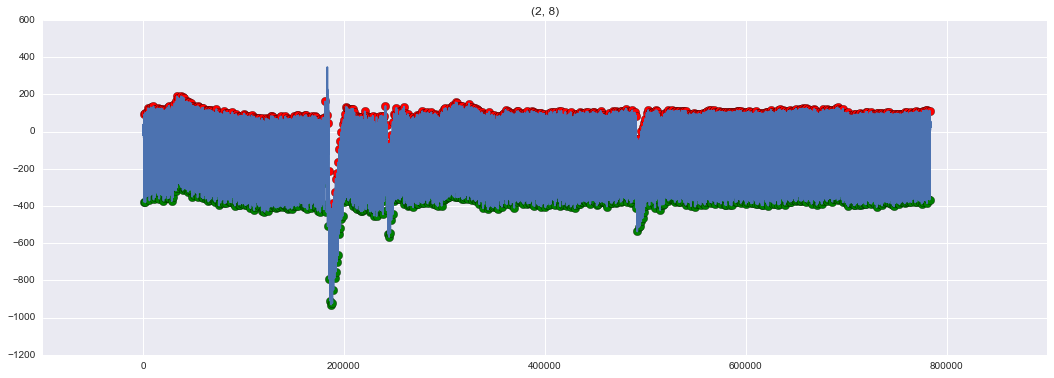

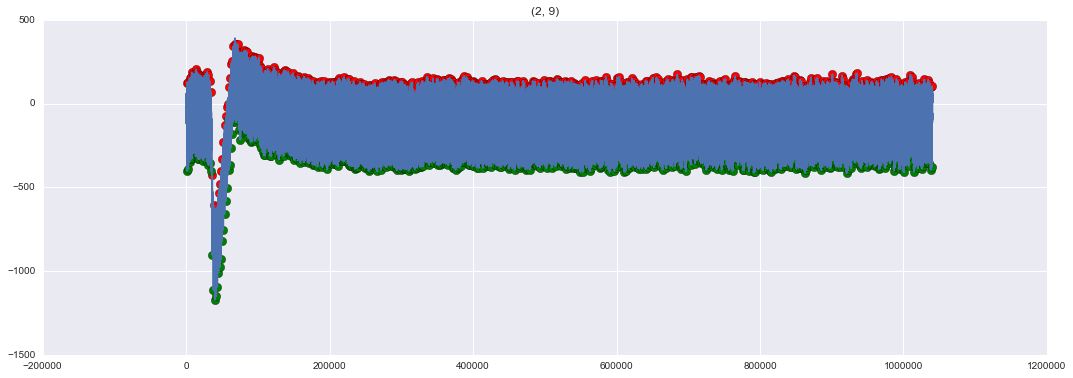

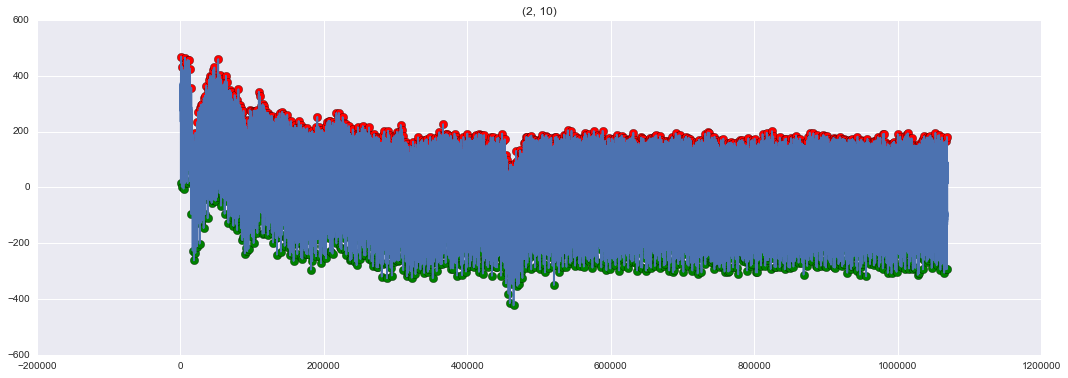

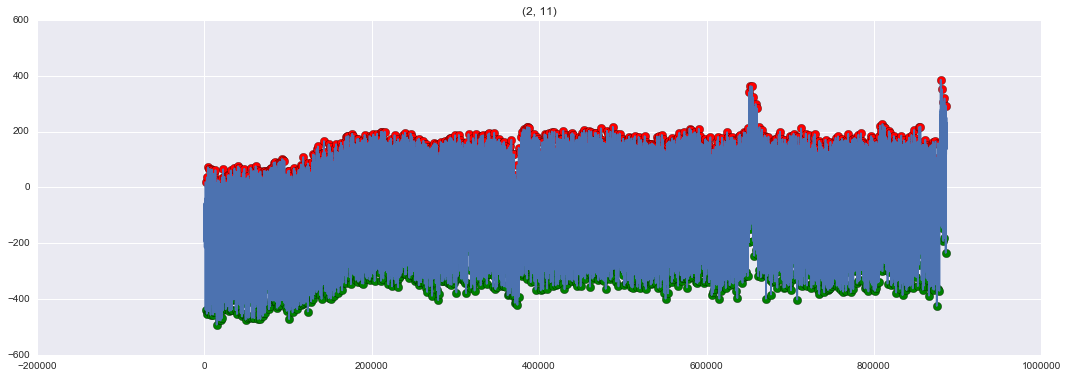

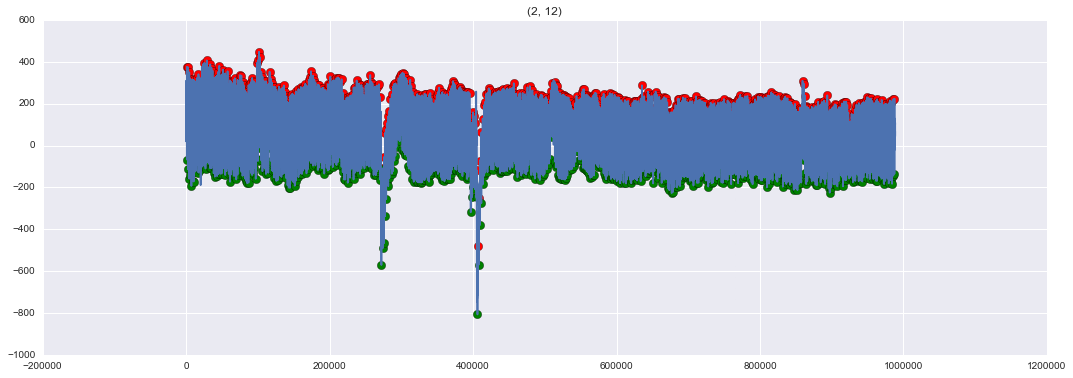

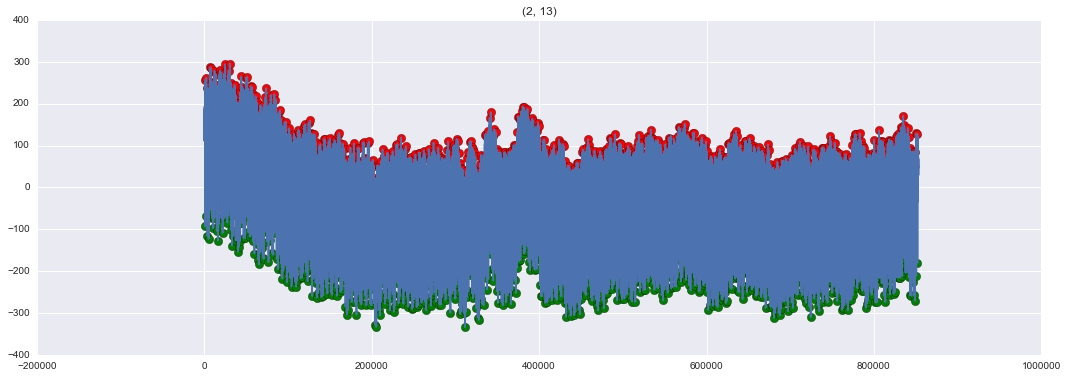

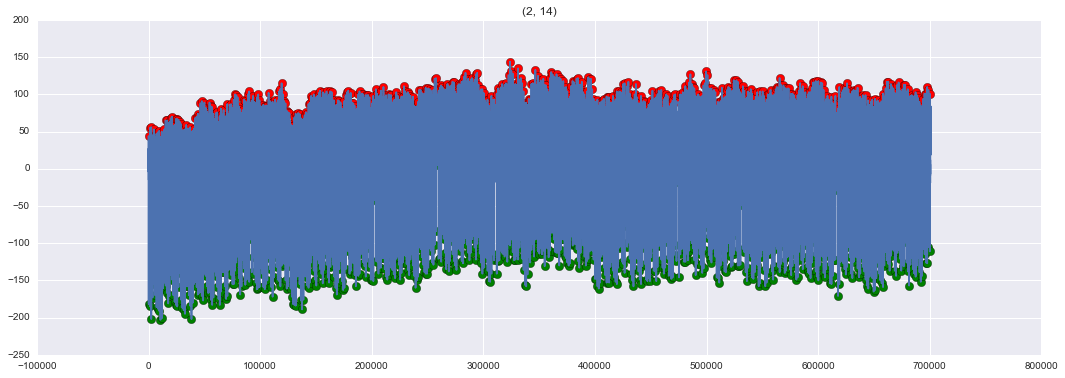

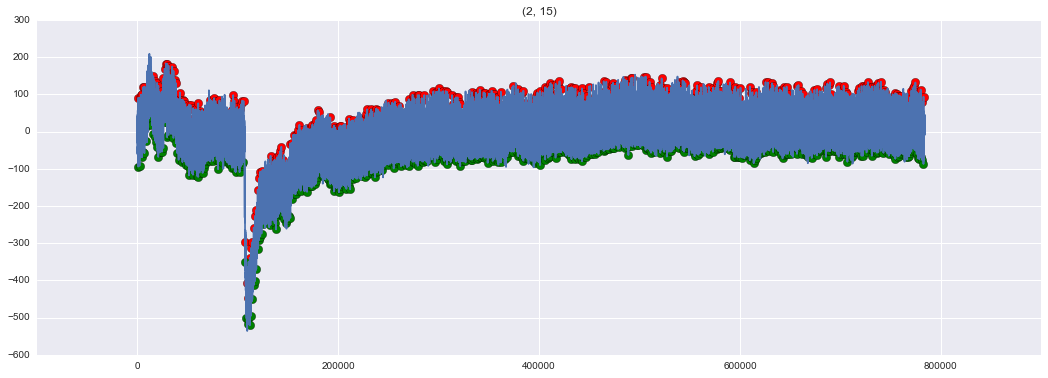

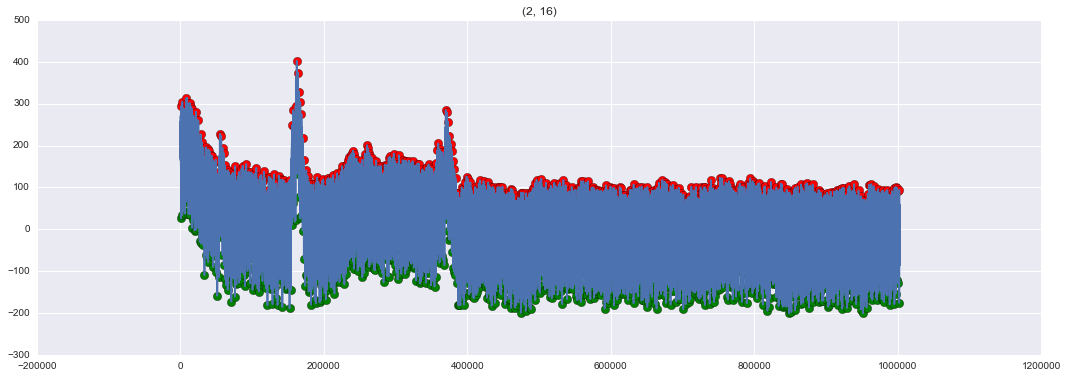

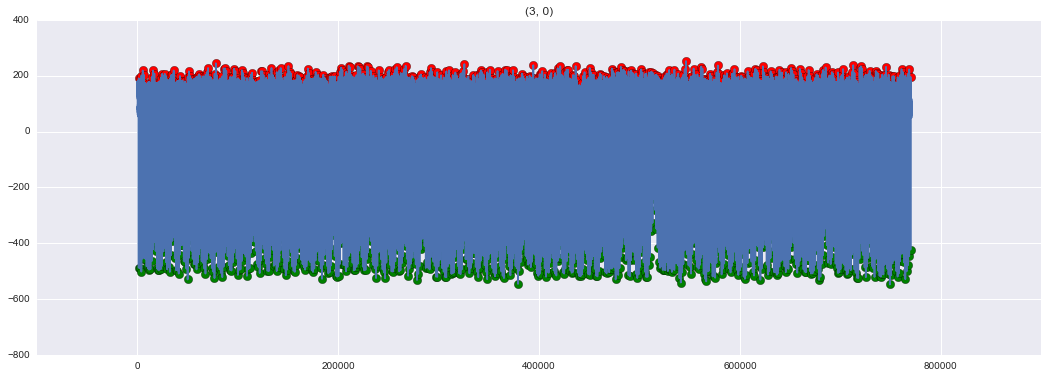

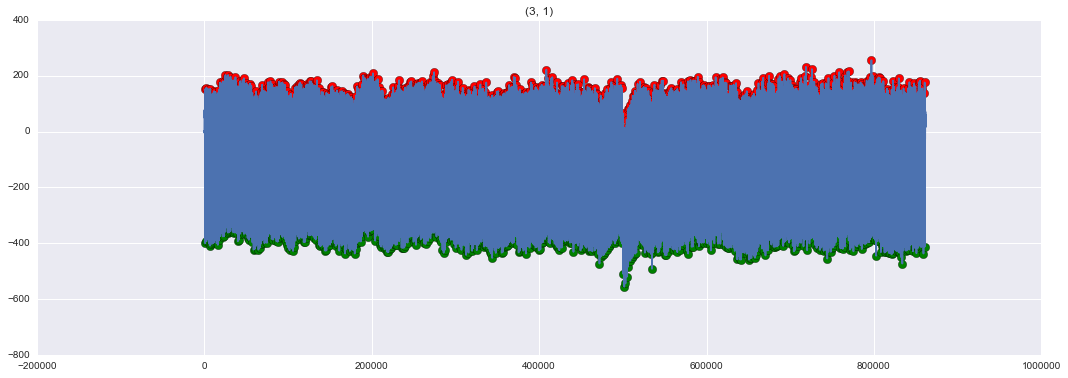

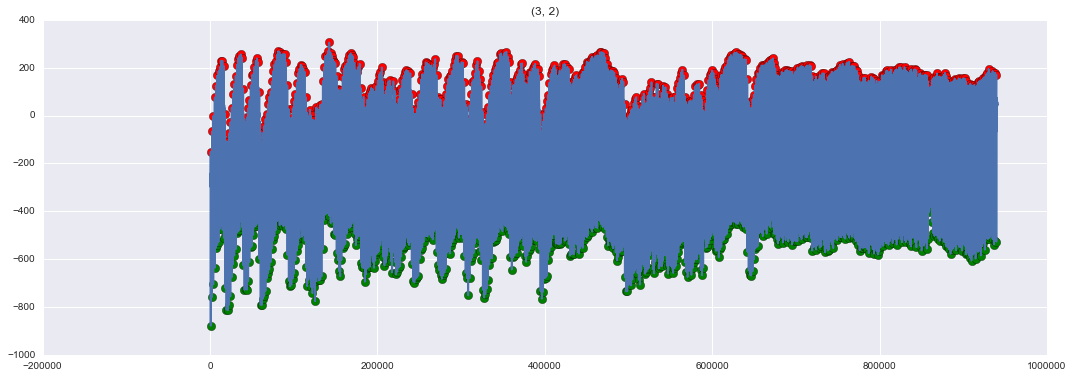

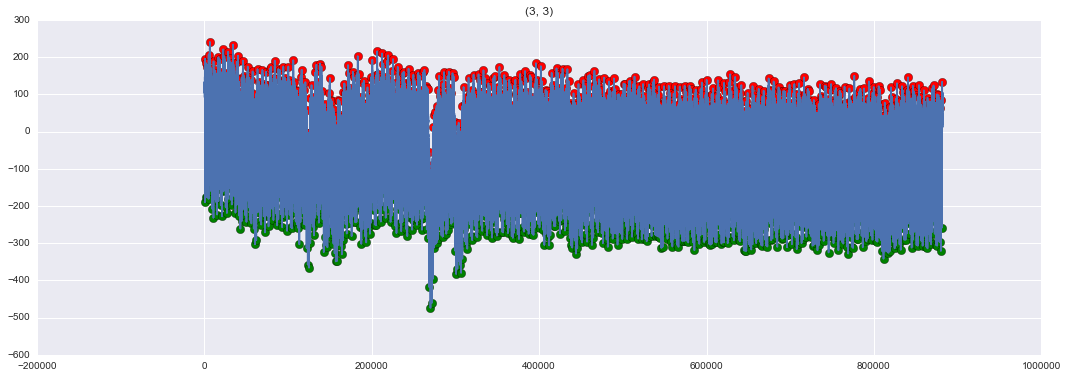

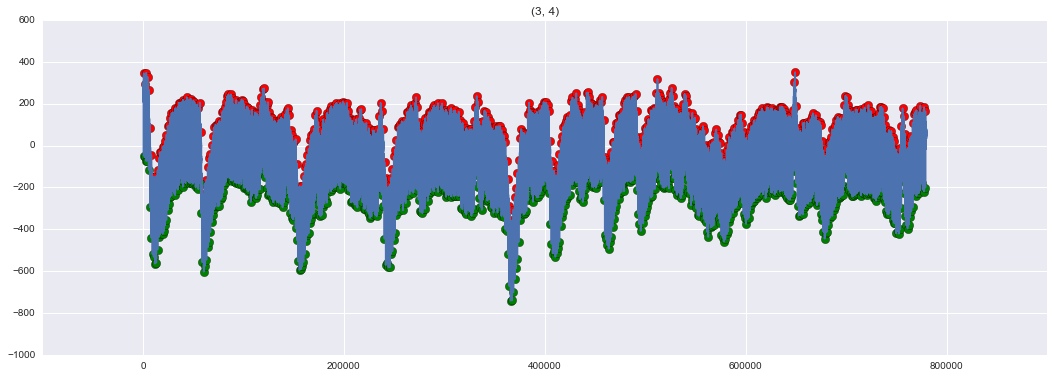

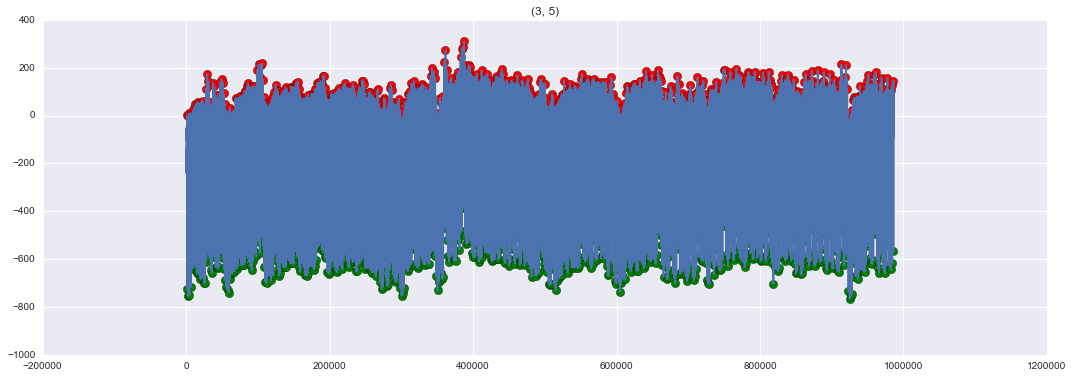

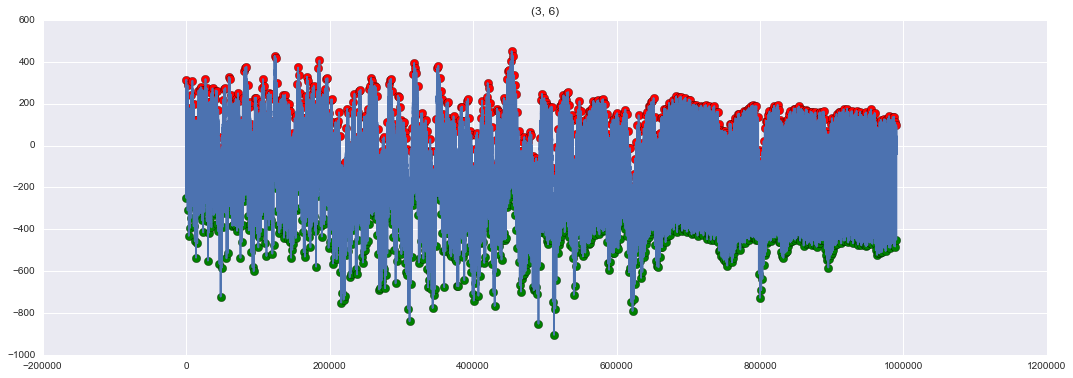

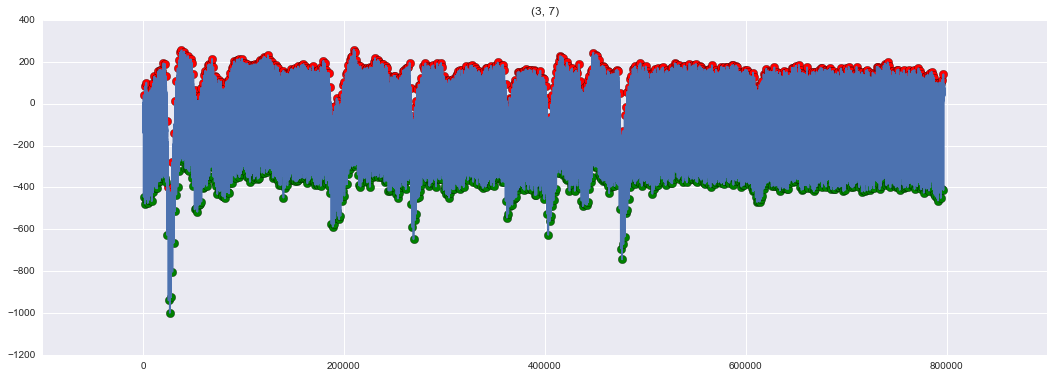

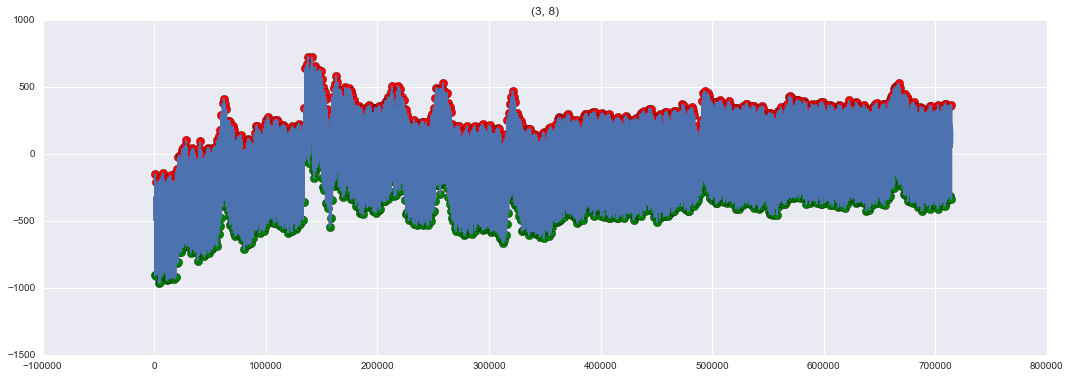

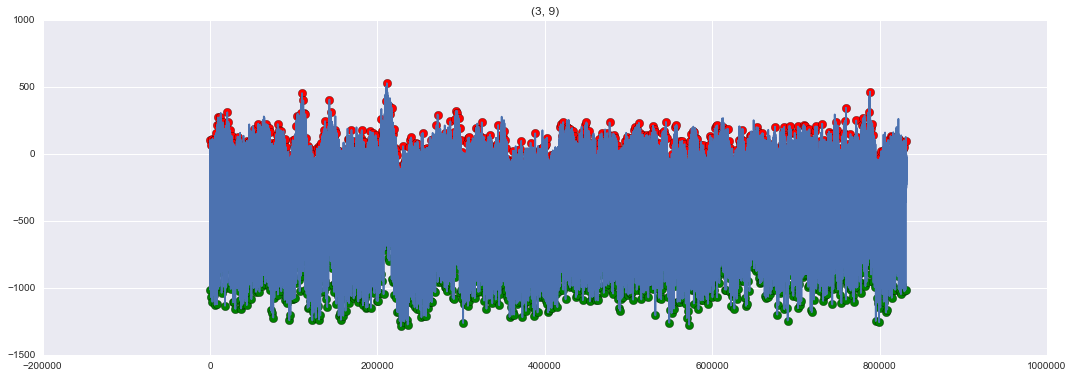

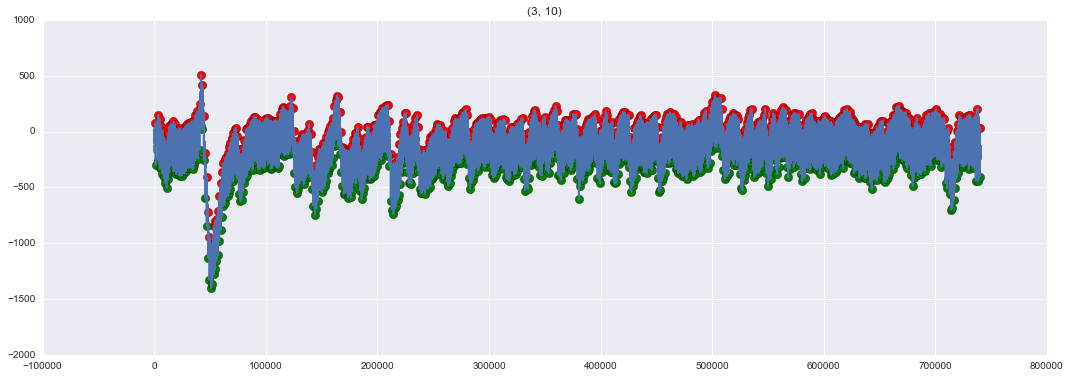

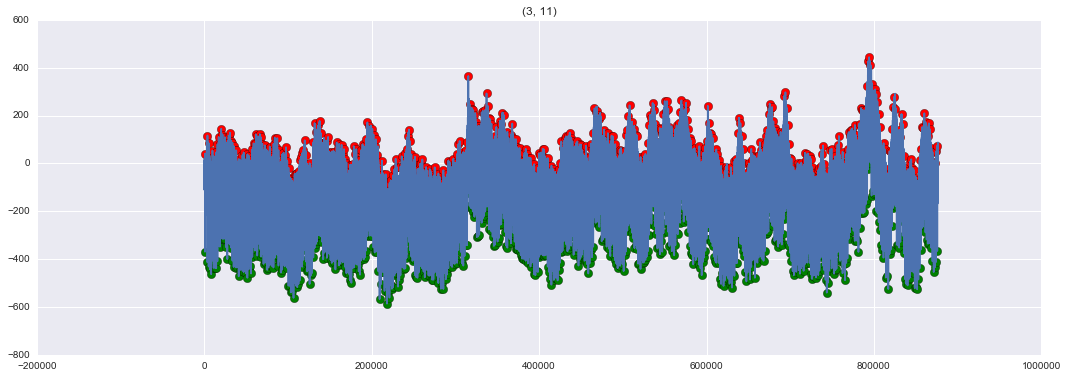

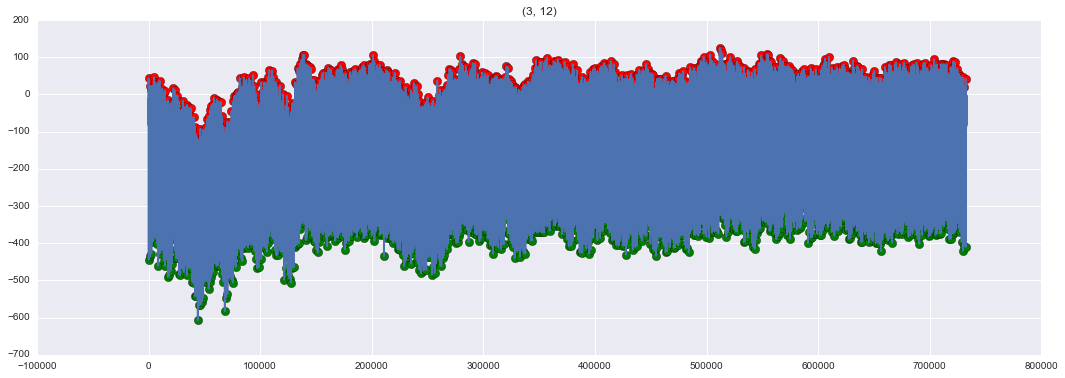

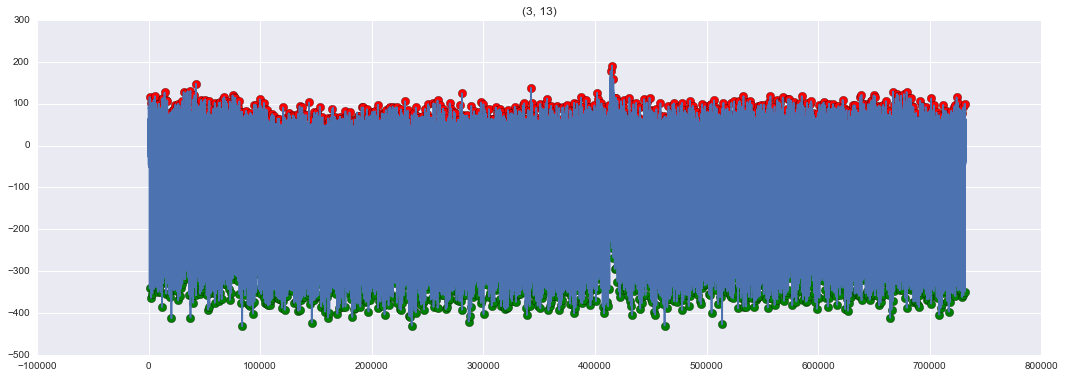

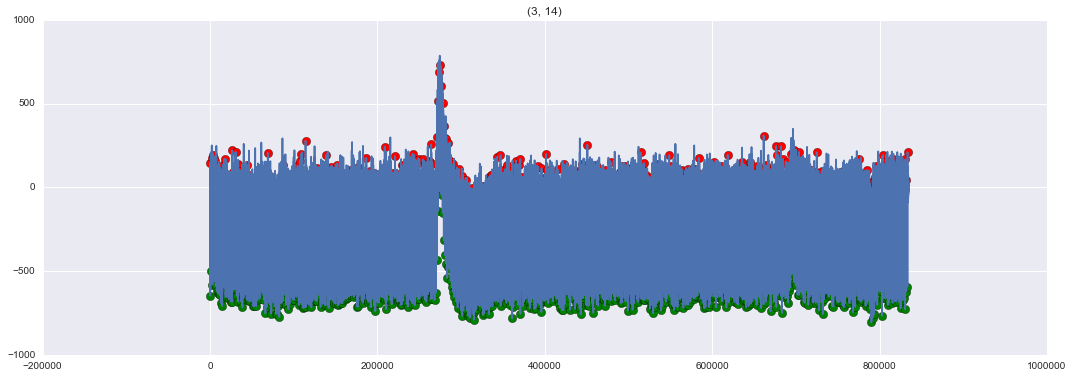

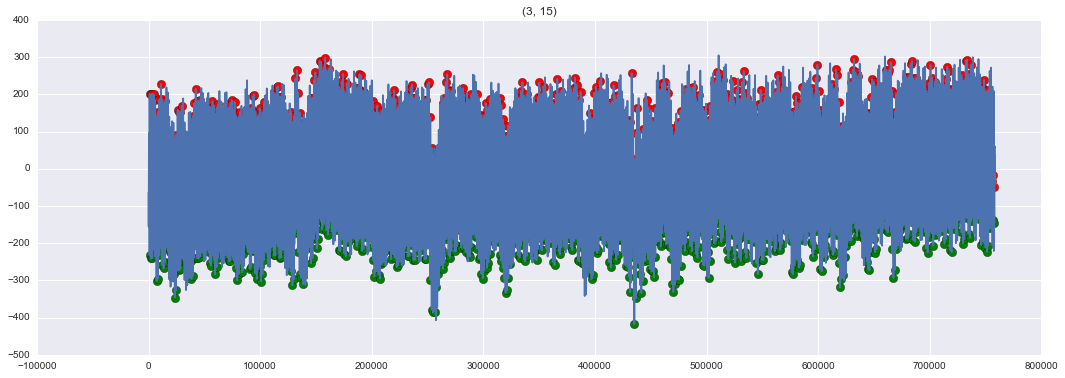

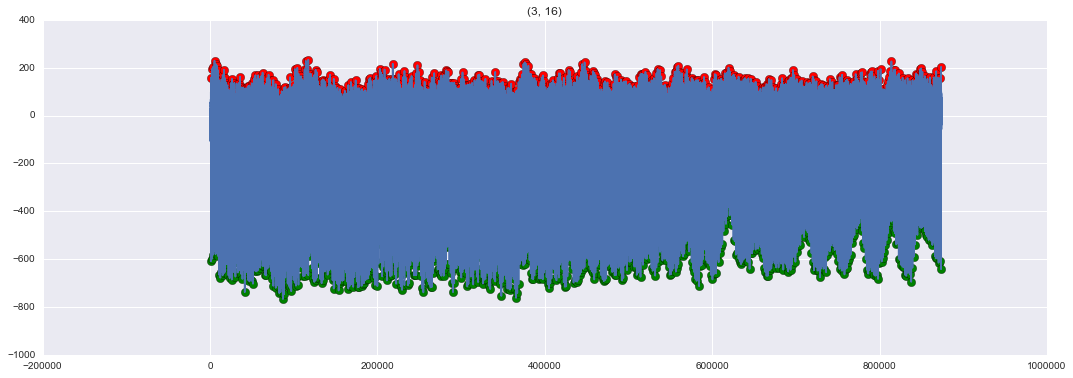

In [150]:
for i, files in enumerate(kdms):
    for j, f in enumerate(files):
        drawSignal(f)
        plt.title("({}, {})".format(i, j))

Запись интервалов и амплитуд по файлам в папке с классификатором

In [32]:
 for block, name_block in zip(ai_all, kdms_name):
    for (intervals, amplitudes), name in zip(block, name_block):
        f = open("C:/Users/aksho/GDrive/Documents/MIPT/cardio/classifier_test/patients/" + name, 'w')
        for (interval, amplitude) in zip(intervals, amplitudes):
            f.write("{}\t{}\n".format(int(amplitude), int(interval)))
        f.close()

Создание списков файлов в папке с классификатором

In [33]:
from os import listdir
from os.path import isfile, join

for i in range(4):
    mypath = "C:/Users/aksho/GDrive/Documents/MIPT/cardio/Supervised KDMs/" + str(i) + "/"
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    f = open("C:/Users/aksho/GDrive/Documents/MIPT/cardio/classifier_test/" + str(i), 'w')
    for t in onlyfiles:
        f.write(t + '\n')
    f.close()

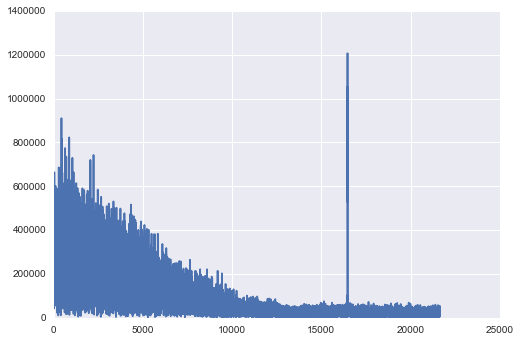

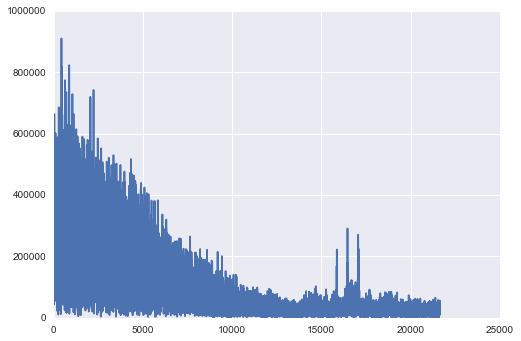

In [51]:
# plt.plot(kdms[0][0][1000:2500], c='b')
# plt.plot(cleaned[1000:2500], c='r')
rfft_t = np.abs(rfft(kdms[0][0]))
a, b = hz(len(kdms[0][0]), 2000, 20, 60)
plt.plot(rfft_t[a:b])
plt.figure()
rfft_t2 = np.abs(rfft(cleaned))
a, b = hz(len(kdms[0][0]), 2000, 20, 60)
plt.plot(rfft_t2[a:b])

Очистка КДМок, создание амплитудно-интервальных файлов, создание файлов-индексов

In [56]:
cleaned_kdms = []

In [ ]:
for i, block in enumerate(kdms):
    pb = FloatProgress(min=0, max = len(block))
    display(pb)
    mid = []
    for j, f in enumerate(block):
        mid.append(STFT_cleaning(f)[0])
        print("{},{}".format(i, j))
        pb.value+=1
    cleaned_kdms.append(mid)

In [59]:
ai_all_cleaned = []
for i, files in enumerate(cleaned_kdms):
    mid = []
    pb2 = FloatProgress(min=0, max=len(files)) 
    display(pb2)
    for j, f in enumerate(files):
        mn, mx = getExtremaSuperFast(f)
        #print("({},{}): {} - {}".format(i, j, np.abs(mn[0] - mx[0]), np.abs(mn[-1] - mx[-1])))
        pb2.value+=1
        
        intervals = []
        for a, b in zip(mn[:-1], mn[1:]):
            intervals.append(b-a)
            
        amplitudes = []
        for a, b in zip(mn, mx):
            amplitudes.append(f[b]-f[a])
            
        mid.append((intervals, amplitudes))
    ai_all_cleaned.append(mid)

In [61]:
 for block, name_block in zip(ai_all_cleaned, kdms_name):
    for (intervals, amplitudes), name in zip(block, name_block):
        f = open("C:/Users/aksho/GDrive/Documents/MIPT/cardio/classifier_cleaned/patients/" + name, 'w')
        for (interval, amplitude) in zip(intervals, amplitudes):
            f.write("{}\t{}\n".format(int(amplitude), int(interval)))
        f.close()

In [62]:
from os import listdir
from os.path import isfile, join

for i in range(4):
    mypath = "C:/Users/aksho/GDrive/Documents/MIPT/cardio/Supervised KDMs/" + str(i) + "/"
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    f = open("C:/Users/aksho/GDrive/Documents/MIPT/cardio/classifier_cleaned/" + str(i), 'w')
    for t in onlyfiles:
        f.write(t + '\n')
    f.close()

Кросс-валидация c->n

In [19]:
from copy import deepcopy

train = []
test = []

for i, files in enumerate(kdms_name):
    ts = np.random.permutation(files)[:len(files)/4+1]
    tr = deepcopy(files)
    for f in ts:
        tr.remove(f)
    train.append(tr)
    test.append(ts)
    print "{})\n train: {} \n test: {}".format(i, tr, ts)

answers = [[]]*4
for i in range(3):
    f = open("C:/Users/aksho/GDrive/Documents/MIPT/cardio/classifier_splitted/" + str(i) + "_train", 'w')
    for t in train[i]:
        f.write(t + '\n')
    f.close()
    for j in range(i+1, 4):
        f = open("C:/Users/aksho/GDrive/Documents/MIPT/cardio/classifier_splitted/" + "{}-{}_test".format(i,j), 'w')
        for t in test[i]:
            f.write(t + '\n')
        for t in test[j]:
            f.write(t + '\n')
        f.close()
        f = open("C:/Users/aksho/GDrive/Documents/MIPT/cardio/classifier_splitted/" + "{}-{}_answers".format(i,j), 'w')
        for t in [0]*len(test[i]) + [1]*len(test[j]):
            f.write(str(t) + '\n')
        f.close()
        answers[i].append([0]*len(test[i]) + [1]*len(test[j]))
        
f = open("C:/Users/aksho/GDrive/Documents/MIPT/cardio/classifier_splitted/" + str(3) + "_train", 'w')
for t in train[3]:
    f.write(t + '\n')
f.close()

0)
 train: ['292.txt', '294.txt', '295.txt', '298.txt', '303.txt', '304.txt', '311.txt', '315.txt', '317.txt', '318.txt', '332.txt', '333.txt', '334.txt', '335.txt', '336.txt', '338.txt', '340.txt', '341.txt', '342.txt', '343.txt', '344.txt', '345.txt', '346.txt', '347.txt', '348.txt', '349.txt', '350.txt'] 
 test: ['339.txt' '308.txt' '305.txt' '307.txt' '291.txt' '303 (1).txt' '310.txt'
 '337.txt' '302.txt' '312.txt']
1)
 train: ['100.txt', '101.txt', '104.txt', '107.txt', '110.txt', '111.txt', '112.txt', '114.txt', '116.txt', '117.txt', '13.txt', '132.txt', '133.txt', '134.txt', '135.txt', '137.txt', '138.txt', '139.txt', '140.txt', '143.txt', '145.txt', '146.txt', '147.txt', '148.txt', '96.txt', '99.txt'] 
 test: ['144.txt' '130.txt' '103.txt' '97.txt' '131.txt' '136.txt' '149.txt'
 '102.txt' '108.txt' '142.txt']
2)
 train: ['22.txt', '33.txt', '37.txt', '39.txt', '40.txt', '42.txt', '47.txt', '49.txt', '54.txt', '55.txt', '56.txt', '58.txt', '73.txt', '74.txt', '75.txt', '76.txt',

Парсинг результатов работы классификатора Влады

In [119]:
from sklearn.metrics import roc_auc_score

#args = [c/n, alg, who, with_whom]
quality = np.zeros((4,3,4,4))

for i in range(3):
    for j in range(i+1, 4):
        for k, s in enumerate(['c', 'n']):
            path = "C:/Users/aksho/GDrive/Documents/MIPT/cardio/classifier_reports/{}-{}{}/".format(i, j, s)
            for alg_num in range(1,4):
                data = [float(f) for f in open(path+"alg"+str(alg_num)+"/quality.txt").readlines()[2][:-1].split('\t')]
                quality[k, alg_num-1, i, j] = data[1]
                #print "{}-{}{}-{}):{} - {}".format(i, j, s, alg_num, quality[k, alg_num-1, i, j], data)
                
for i in range(3):
    for j in range(i+1, 4):
        for k, s in enumerate(['cn', 'nc']):
            path_ans = "C:/Users/aksho/GDrive/Documents/MIPT/cardio/classifier_reports/{}-{}{}/".format(i, j, s)
            path_true_ans = "C:/Users/aksho/GDrive/Documents/MIPT/cardio/classifier_splitted/{}-{}_answers".format(i, j)
            true_ans = pd.Series([int(f[:-1]) for f in open(path_true_ans).readlines()])
            for alg_num in range(1, 4):
                ans = pd.read_csv(path_ans+"alg"+str(alg_num)+"/testResults.txt", sep='\t')
                quality[k+2, alg_num-1, i, j] = roc_auc_score(true_ans, ans["score"])
                #print i, j, s, alg_num, quality[k+2, alg_num-1, i, j]

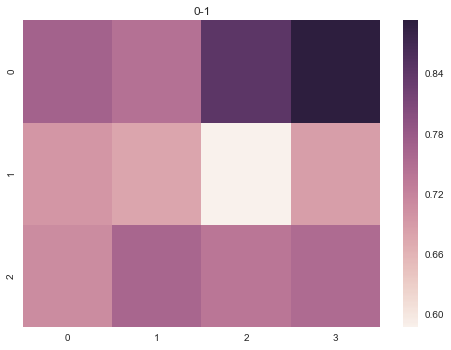

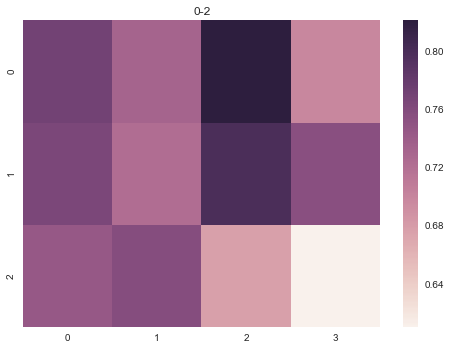

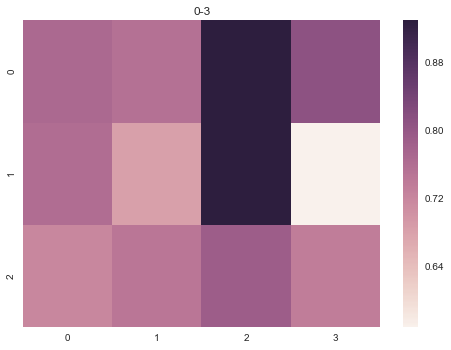

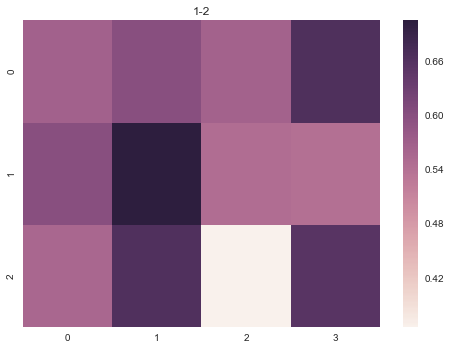

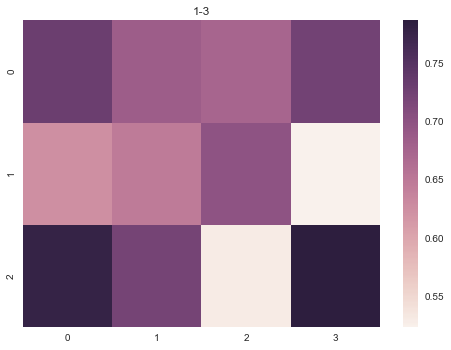

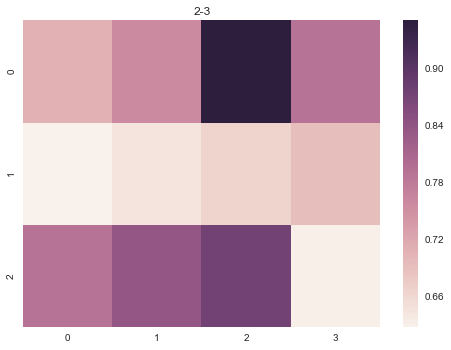

In [130]:
for i1 in range(0, 3):
    for i2 in range(i1+1, 4):
        score_map = np.zeros((3, 4))
        for j in range(3):
            for i in range(4):
                score_map[j, i] = quality[i, j, i1, i2]
        plt.figure()
        sns.heatmap(score_map)
        plt.title("{}-{}".format(i1, i2))

In [177]:
delta_quality_cn = []
delta_quality_nc = []
algs_delta_quality = [[], [], []]
algs_delta_quality_cn = [[], [], []]
algs_delta_quality_nc = [[], [], []]
algs = ["RF", "SA", "LR-PCA"]
for i1 in range(0, 3):
    for i2 in range(i1+1, 4):
        print "{}-{}".format(i1, i2)
        for alg_num in range(3):
            qcc = quality[0][alg_num][i1][i2]
            qcn = quality[2][alg_num][i1][i2]
            dc = qcn - qcc
            qnn = quality[1][alg_num][i1][i2]
            qnc = quality[3][alg_num][i1][i2]
            dn = qnc - qnn
            print "cn-%-8s: %6.4f %6.4f %+6.4f" % (algs[alg_num], qcc, qcn, dc)
            print "nc-%-8s: %6.4f %6.4f %+6.4f" % (algs[alg_num], qnn, qnc, dn)
            delta_quality_cn.append(dc)
            delta_quality_nc.append(dn)
            algs_delta_quality[alg_num].extend([dn, dc])
            algs_delta_quality_nc[alg_num].append(dn)
            algs_delta_quality_cn[alg_num].append(dc)
            
delta_quality = delta_quality_cn + delta_quality_nc

0-1
cn-RF      : 0.7681 0.8444 +0.0763
nc-RF      : 0.7469 0.8944 +0.1475
cn-SA      : 0.6971 0.5889 -0.1083
nc-SA      : 0.6806 0.6889 +0.0083
cn-LR-PCA  : 0.7114 0.7389 +0.0275
nc-LR-PCA  : 0.7623 0.7556 -0.0068
0-2
cn-RF      : 0.7720 0.8222 +0.0502
nc-RF      : 0.7338 0.7000 -0.0338
cn-SA      : 0.7662 0.8000 +0.0338
nc-SA      : 0.7242 0.7556 +0.0314
cn-LR-PCA  : 0.7461 0.6778 -0.0684
nc-LR-PCA  : 0.7589 0.6111 -0.1478
0-3
cn-RF      : 0.7684 0.9306 +0.1622
nc-RF      : 0.7553 0.8125 +0.0572
cn-SA      : 0.7628 0.9306 +0.1678
nc-SA      : 0.6841 0.5694 -0.1146
cn-LR-PCA  : 0.7212 0.7917 +0.0704
nc-LR-PCA  : 0.7464 0.7361 -0.0103
1-2
cn-RF      : 0.5683 0.5667 -0.0016
nc-RF      : 0.6022 0.6667 +0.0644
cn-SA      : 0.6034 0.5500 -0.0534
nc-SA      : 0.7072 0.5444 -0.1627
cn-LR-PCA  : 0.5594 0.3667 -0.1927
nc-LR-PCA  : 0.6651 0.6556 -0.0096
1-3
cn-RF      : 0.7321 0.6750 -0.0571
nc-RF      : 0.6866 0.7250 +0.0384
cn-SA      : 0.6259 0.7000 +0.0741
nc-SA      : 0.6486 0.5250 -0.1236


In [180]:
print "%.3f" % (sp.stats.normaltest(delta_quality).pvalue)
for i in range(3):
    print algs[i]
    print "mean = %4.3f, p-value = %4.3f" % (np.mean(algs_delta_quality[i]),
                                          sp.stats.normaltest(algs_delta_quality[i]).pvalue)
    print "mean = %4.3f, arr: %s" % (np.mean(algs_delta_quality_cn[i]),
                                          algs_delta_quality_cn[i])
    print "mean = %4.3f, arr: %s \n" % (np.mean(algs_delta_quality_nc[i]),
                                          algs_delta_quality_nc[i])

0.682
RF
mean = 0.065, p-value = 0.448
mean = 0.079, arr: [0.076311444444444487, 0.050231222222222205, 0.16220255555555563, -0.0016203333333333347, -0.057081000000000048, 0.24181588888888883]
mean = 0.051, arr: [0.14753044444444452, -0.033796000000000048, 0.057167999999999997, 0.06442866666666669, 0.038429999999999964, 0.032241666666666724] 

SA
mean = -0.013, p-value = 0.886
mean = 0.025, arr: [-0.10825611111111111, 0.033796000000000048, 0.16778255555555543, -0.05339499999999997, 0.074131999999999976, 0.03732666666666673]
mean = -0.052, arr: [0.0083328888888888342, 0.031404555555555547, -0.11464555555555556, -0.16273155555555552, -0.12362399999999996, 0.048053444444444371] 

LR-PCA
mean = -0.054, p-value = 0.318
mean = -0.055, arr: [0.027468888888888765, -0.06836422222222216, 0.070436666666666592, -0.19274733333333333, -0.24764399999999998, 0.08333299999999999]
mean = -0.053, arr: [-0.0067904444444444323, -0.14776188888888886, -0.010292888888888796, -0.0095674444444444617, 0.064782000

Сравнение результатов Влады и моих

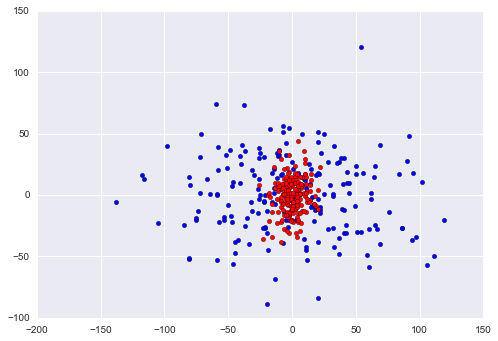

In [229]:
illness_num = 3 #!!!!!
kdm_num = 3
mn, mx = getExtremaSuperFast(kdms[illness_num][kdm_num])

my_intervals = []
for a, b in zip(mn[:-1], mn[1:]):
    my_intervals.append(b-a)
    
her_intervals = np.array(kirill_data.iloc[kdm_num, 600:])

my_delta_intervals = []
for a, b in zip(my_intervals[1:-1], my_intervals[2:]):
    my_delta_intervals.append(b-a)
    
her_delta_intervals = []
for a, b in zip(her_intervals[:-1], her_intervals[1:]):
    her_delta_intervals.append(b-a)

my_mean_amplitudes = []
for a, b in zip(mn, mx):
    my_mean_amplitudes.append(kdms[illness_num][kdm_num][b]-kdms[illness_num][kdm_num][a])

my_delta_amplbitudes = []
for a, b in zip(my_mean_amplitudes[1:-1], my_mean_amplitudes[2:]):
    my_delta_amplitudes.append(b-a)

her_mean_amplitudes = np.array(kirill_data.iloc[kdm_num, :600])
    
her_delta_amplitudes = []
for a, b in zip(her_mean_amplitudes[:-1], her_mean_amplitudes[1:]):
    her_delta_amplitudes.append(b-a)
    
lim=200
plt.scatter(my_delta_amplitudes[:lim], her_delta_amplitudes[:lim], c='b')
plt.scatter(my_delta_intervals[:lim], her_delta_intervals[:lim], c='r')

## Lib

In [76]:
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
from numpy.fft import fft, rfft, rfftfreq, irfft

def getQuantDisperce2(a, b, quant_size = 3):
    ans = []
    c = b.copy()
    c.subtract(a)
    for key, w in c.items():
        ans.append((trig_to_num(key), np.sign(w)*(np.abs(w)//quant_size)))
    return ans

def noiseSin(x, a, ampl, shift):
    return ampl*np.exp(2*1j*np.pi*(a)*(x-shift)/512)

def drawSignal(sig, with_min=True, with_max=True, extrema=None, fig_size=(18,6)):
    plt.figure(figsize=fig_size)
    plt.plot(sig)
    if (with_min | with_max):
        mn, mx = getExtremaFastMethod(sig) if extrema == None else extrema
        if (with_max):
            plt.scatter(mx, [sig[x] for x in mx], c='r', s=70)
        if (with_min):
            plt.scatter(mn, [sig[x] for x in mn], c='g', s=70)
        return len (mn)

def readSignalFromFile(file_name):
    splitted = [s.split() for s in open(file_name, 'r').readlines()]
    return pd.DataFrame(splitted, columns=['sig1', 'sig2']).astype(float)

def getDefaultPeak():
    import pickle
    return pickle.load(open('patterns/default_QRS.dump', 'r'))

from sklearn.preprocessing import scale

def getExtrema(signal, peak_criterion=0.7, epsilon=10, model=None):
    
    if (model == None):
        model = getDefaultPeak()
        
    epsilon = len(model)
    scaled = scale(model, with_std=False)
    ideal_max = np.argmax(scaled)
    ideal_min = np.argmin(scaled)
    
    win_len = len(model)
    corr = []
    for i in range(0, len(signal) - win_len):
        corr.append(np.correlate(scaled, scale(signal[i:i+win_len], with_std = False)))

    m = max(corr)
    peaks = np.array([x if x > m*peak_criterion else 0 for x in corr]);
    
    from scipy.signal import argrelextrema
    max_peak_points = argrelextrema(peaks, np.greater) + ideal_max
    min_peak_points = argrelextrema(peaks, np.greater) + ideal_min
    
    def left(x):
        return x-epsilon if (x-epsilon >= 0) else 0
    def right(x):
        return x+epsilon #if (x+epsilon <= len(signal)) else len(signal)
    
    real_max_peak_points = [np.argmax(signal[left(x) : right(x)]) for x in max_peak_points[0]]
    real_min_peak_points = [np.argmin(signal[left(x) : right(x)]) for x in min_peak_points[0]]
    
    #real_max_peak_points = [np.argmax(signal[x-epsilon : x+epsilon]) for x in max_peak_points[0]]
    #real_min_peak_points = [np.argmin(signal[x-epsilon : x+epsilon]) for x in min_peak_points[0]]
    
    return real_min_peak_points, real_max_peak_points


def getExtremaSuperFast(signal, scan_area = 1000, sdf_area = 8000, abs_indexes=False, 
                         min_max_dist=150, max_preferable = False, min_dist_between_extr=1000, delta_min_to_fail=200):
    from sklearn.preprocessing import scale
    mn, mx = getExtrema(pd.Series(signal[:min([sdf_area, len(signal)])]))
    
    delta_max = []
    for i in range(1, len(mx)):
        delta_max.append(mx[i] - mx[i-1])
    
    delta_min = []
    for i in range(1, len(mn)):
        delta_min.append(mn[i] - mn[i-1])
        
    mean_delta_max = int(np.mean(delta_max))
    mean_delta_min = int(np.mean(delta_min))
    
    max_center =  mx[-1] + mean_delta_max
    min_center =  mn[-1] + mean_delta_min
    
    while ((max_center < len(signal)) & (min_center < len(signal))):
        llim, rlim = np.max([0, max_center - scan_area/2]), np.min([max_center + scan_area/2, len(signal)])
        current_max = max_center - scan_area/2 + np.argmax(signal[llim:rlim])
        llim, rlim = np.max([0, min_center - scan_area/2]), np.min([min_center + scan_area/2, len(signal)])
        current_min = min_center - scan_area/2 + np.argmin(signal[llim:rlim])
        
        if (np.abs(current_min - current_max) > min_max_dist):
            if (max_preferable):
                llim, rlim = np.max([0, min_center - min_max_dist/2]), np.min([min_center + min_max_dist/2, len(signal)])
                current_min = min_center - min_max_dist/2 + np.argmin(signal[llim:rlim])
            else:
                llim, rlim = np.max([0, current_min - min_max_dist/2]), np.min([current_min + min_max_dist/2, len(signal)])
                current_max = current_min - min_max_dist/2 + np.argmax(signal[llim:rlim])    
        #!!! 
        if (current_max - mx[-1] <= min_dist_between_extr):
            current_max += int(np.mean(delta_max))
        if (current_min - mn[-1] <= min_dist_between_extr):
            current_min += int(np.mean(delta_min))

        delta_max.pop(0)
        delta_max.append(current_max - mx[-1])
        delta_min.pop(0)
        delta_min.append(current_min - mn[-1])
        mx.append(current_max)
        mn.append(current_min)
        max_center = current_max + int(np.mean(delta_max))
        min_center = current_min + int(np.mean(delta_min))
    
    return mn, mx

def analyzeLiterals(s, extrema = None):
    if (extrema == None):
        mn, mx = getExtremaSuperFast(s)
    else:
        mn, mx = extrema
    periods = []
    delta_periods = []
    amplitudes = []
    delta_amplitudes = []
    angles = []
    delta_angles = []
    abs_deltas = []
    for i in range(len(mn)-1):
        p = mn[i+1]-mn[i]
        periods.append(np.abs(p))
        am = np.abs(s[mx[i]] - s[mn[i]])
        amplitudes.append(am)
        angles.append(float(am)/p)
        if (i >= 1):
            delta_periods.append((periods[i] - periods[i-1])>=0)
            delta_amplitudes.append((amplitudes[i]-amplitudes[i-1])>=0)
            abs_deltas.append(np.abs(amplitudes[i]-amplitudes[i-1]))
            delta_angles.append((angles[i]-angles[i-1])>=0)
    deltas = zip(delta_amplitudes, delta_periods, delta_angles)
    
    for i in range(len(deltas)):
        if ((deltas[i] == (True, False, False)) | (deltas[i]==(False, True, True))):
            print deltas[i]
            print amplitudes[i-1], amplitudes[i]
            print periods[i-1], periods[i]
            print angles[i-1], angles[i]
    
    liters_dict = {
        (True, True, True) : "A",
        (False, False, True) : "B",
        (True, False, True) : "C",
        (False, True, False) : "D",
        (True, True, False) : "E",
        (False, False, False) : "F"
    }

    literals = [liters_dict[c] for c in deltas]
    
    from collections import Counter
    codograms = Counter()
    for i in range(len(literals)-3):
        win = literals[i:i+3]
        code = ''.join(win)
        codograms[code] += 1
        
    return codograms, literals, abs_deltas

def getMids(points):
    prev= points[0]
    mids = []
    for i in points[1:]:
        center = (i + prev)/2
        mids.append(center)
        prev = i
    return mids

# функция для перевода герцевого диапазона в числовой. Делает то же самое, что rfftfreq, но для двух точек.
def hz(N, d, a, b):
    return int((N)*float(a)/(d)), int((N)*float(b)/(d))

def trig_to_num(trigram):
    t = {
        'A' : 0,
        'B' : 1,
        'C' : 2,
        'D' : 3,
        'E' : 4,
        'F' : 5
    }
    return 36*t.get(trigram[0]) + 6*t.get(trigram[1]) + t.get(trigram[2])


def num_to_trig(num):
    t = {
        0 : 'A',
        1 : 'B',
        2 : 'C',
        3 : 'D',
        4 : 'E',
        5 : 'F'
    }
    first = t.get(num % 6)
    second = t.get((num//6)%6)
    third = t.get(((num//6)//6)%6)
    return third + second + first

def deSocket(sig, fd, interval=(40, 60)):
    from numpy.fft import rfft, rfftfreq
    
    #mn, mx = getExtrema(sig, model)
    
    spectrum = rfft(sig)
    x_axis = rfftfreq(len(sig), 1./fd)
    a,b = hz(len(sig), fd, interval[0], interval[1])
    w = np.argmax(np.abs(spectrum[a:b])) #частота 
    A = spectrum[a+w]/len(sig) #амплитутда
    
    def cos_to_remove(x):
        return (2.)*A*np.exp(2*1j*np.pi*(a+w)*(x-len(sig)/2)/len(sig))

    cos_graph = [cos_to_remove(x) for x in range(len(sig))]
    return cos_graph + sig


def deSocketFull(sig, fd=2000, interval=(40, 60), delta=256, border=50):
    from numpy.fft import rfft, rfftfreq
    from sklearn.preprocessing import scale as sc
    clr_sig = sig.copy()
    
    mid_ampl = []
    mn, mx = getExtremaSuperFast(clr_sig)
    mids1 = getMids(mx)
    mx1 = sorted(np.concatenate([mids1, mx]))
    mids = getMids(mx1)
    for i in range(len(mids)):
        sig_part = clr_sig[mids[i]-delta/2 : mids[i]+delta/2]
        spectrum = rfft(sig_part)
        x_axis = rfftfreq(len(sig_part), 1./fd)
        a,b = hz(len(sig_part), fd, interval[0], interval[1])
        w = np.argmax(np.abs(spectrum[a:b])) #частота
        A = spectrum[a+w]/len(sig_part) #амплитутда
        mid_ampl.append(np.abs(2.*A))
        def cos_to_remove(x):
            return (2.)*A*np.exp(2*1j*np.pi*(a+w)*(x)/len(sig_part))

        left = mids[i]-delta/2-200
        left = left if left > 0 else 0
        right = mids[i]+delta/2+200
        right = right if right < len(clr_sig) else len(clr_sig)-1
        #cos_graph = [cos_to_remove(x) for x in range(len(sig[mx[i]:mx[i+1]]) + 2*border)]
        cos_graph = [cos_to_remove(x) for x in range(-(right-left)/2, (right-left)/2)]
        #plt.figure()
        #plt.plot(sc(sig_part.values, with_std=False), c='r')
        #plt.plot(cos_graph, c='g')
        #plt.figure()
        #plt.plot(spectrum[a:b])
        #plt.scatter([w], spectrum[a+w])
        graph_len = len(cos_graph) -1
        
        scale = border
        for j in range(scale):
            cos_graph[j] *= float(j)/(scale)
            cos_graph[graph_len-j] *= float(j)/(scale)

        
        clr_sig[left:right] += np.real(cos_graph)
    return clr_sig, np.mean(mid_ampl)

def withPB(func, arr):
    i = 0
    f = FloatProgress(min=0, max=len(arr))
    display(f)
    new_arr = []
    for p in arr:
        new_arr.append(func(p))
        i+=1
        f.value = i
    return new_arr

def half_cos(delta):
    return np.array([np.cos(2*np.pi*x/float(delta)) + 1 for x in range(-delta/2, delta/2)])

def STFT_cleaning(sig, fd=2000, interval=(40, 60), delta=512, border=50):
    from numpy.fft import rfft, rfftfreq
    from sklearn.preprocessing import scale as sc
    clr_sig = sig.copy()
    
    mid_ampl = []
    mn, mx = getExtremaSuperFast(clr_sig)
    mids = getMids(mx)
    for i in range(len(mids)):
        sig_part = np.array(clr_sig[mids[i]-delta/2 : mids[i]+delta/2])*half_cos(delta)
        spectrum = rfft(sig_part)
        a,b = hz(len(sig_part), fd, interval[0], interval[1])
        w = np.argmax(np.abs(spectrum[a:b])) #частота 
        A = spectrum[a+w]/len(sig_part) #амплитутда
        mid_ampl.append(np.abs(2.*A))
        def cos_to_remove(x):
            return (2.)*A*np.exp(2*1j*np.pi*(a+w)*(x)/len(sig_part))

        left = mx[i]-border/2
        left = left if left > 0 else 0
        right = mx[i+1]+border/2
        right = right if right < len(clr_sig) else len(clr_sig)-1
        cos_graph = [cos_to_remove(x) for x in range(-(right-left)/2, (right-left)/2)]
        graph_len = len(cos_graph) -1
        
        scale = border
        for j in range(scale):
            cos_graph[j] *= float(j)/(scale)
            cos_graph[graph_len-j] *= float(j)/(scale)
        
        clr_sig[left:right] += np.real(cos_graph)
    return clr_sig, np.mean(mid_ampl)

In [74]:
import numpy as np
import pickle
from scipy.signal import argrelextrema
from sklearn.preprocessing import scale

"""
Get the default parrern of QRS-signal, stored as a pickle dump of a array.
It must contain exactly one QRS cycle. The best way is to cut this sample directly from your file, but a common 
pattern works good enough. You can replace it whatever returns array-like with a pattern.
ARGS:
    path - path to the pattern
RETURNS:
    model - array-like with a pattern
"""
def getDefaultPeak(path='patterns/default_QRS.dump'):
    return pickle.load(open(path, 'r'))

"""
Find (min(Q, S), R) - coordinates of every heart cycle in signal. It's based on the "convolve" method, slow but accurate.
Can be used when fast methods fail.  
ARGS:
    signal - 1-D array-like sequence of values
    peak_criterion - int, regulates sensitivity of peaks recognition. 
    model - array-like with a QRS-pattern
"""
def getExtremaCorrMethod(signal, peak_criterion=0.7, model=None):
    
    assert peak_criterion < 1
    
    if (model == None):
        model = getDefaultPeak()

    epsilon=len(model)
    scaled = scale(model, with_std=False)
    ideal_max = np.argmax(scaled)
    ideal_min = np.argmin(scaled)
    
    win_len = len(model)
    corr = []
    for i in range(0, len(signal) - win_len):
        corr.append(np.correlate(scaled, scale(signal[i:i+win_len], with_std = False)))

    m = max(corr)
    peaks = np.array([x if x > m*peak_criterion else 0 for x in corr]);
    
    max_peak_points = argrelextrema(peaks, np.greater) + ideal_max
    min_peak_points = argrelextrema(peaks, np.greater) + ideal_min
    
    def left(x):
        return x-epsilon if (x-epsilon >= 0) else 0
    def right(x):
        return x+epsilon if (x+epsilon <= len(signal)) else len(signal)
    
    real_max_peak_points = [np.argmax(signal[left(x) : right(x)]) for x in max_peak_points[0]]
    real_min_peak_points = [np.argmin(signal[left(x) : right(x)]) for x in min_peak_points[0]]
    
    return real_min_peak_points, real_max_peak_points

"""
Find (min(Q, S), R) - coordinates of every heart cycle in signal. Fast, but less sustainable. Works ONLY with a "good" signals:
peaks must be noticeable. Q/S should be a local (r=scan_area/2) minimum, R should be max. Practically works well, but optimal
parameters should be found manually for your dataset.
ARGS:
    signal - 1-D array-like sequence of values
    scan_area - width of mean QRS-cycle. The bigger - the better, but slower. Also must be less then R-R interval.
    sdf_area - first N points of the signal, which analyze using convolve-method. It's used to estimate mean R-R intervals.
    max_RS_dist - max accepable dimmension between Q/S ans R (min and max). If bigger, then see max_preferable
    max_preferable - boolean - if true, then R coordinate is always considered safer. If not, then Q/S is considered safer. 
        Used in ad-hoc online fixing. If in your signal R peaks are better noticeable then Q/S then max_preferable should be true.
    min_dist_between_extr - if R or Q/S coordinates come closer to previous QRS, then coordinates recalculated. Used to fight 
        with HRV-effects. 
"""
def getExtremaFastMethod(signal, scan_area = 1000, sdf_area = 8000,
                         max_RS_dist=150, max_preferable = False, min_dist_between_extr=1000):
    from sklearn.preprocessing import scale
    mn, mx = getExtremaCorrMethod(signal[:min([sdf_area, len(signal)])])
    
    delta_max = []
    for i in range(1, len(mx)):
        delta_max.append(mx[i] - mx[i-1])
    
    delta_min = []
    for i in range(1, len(mn)):
        delta_min.append(mn[i] - mn[i-1])
        
    mean_delta_max = int(np.mean(delta_max))
    mean_delta_min = int(np.mean(delta_min))
    
    max_center =  mx[-1] + mean_delta_max
    min_center =  mn[-1] + mean_delta_min
    
    while ((max_center < len(signal)) & (min_center < len(signal))):
        llim, rlim = np.max([0, max_center - scan_area/2]), np.min([max_center + scan_area/2, len(signal)])
        current_max = max_center - scan_area/2 + np.argmax(signal[llim:rlim])
        llim, rlim = np.max([0, min_center - scan_area/2]), np.min([min_center + scan_area/2, len(signal)])
        current_min = min_center - scan_area/2 + np.argmin(signal[llim:rlim])
        
        if (np.abs(current_min - current_max) > max_RS_dist):
            if (max_preferable):
                llim, rlim = np.max([0, min_center - max_RS_dist/2]), np.min([min_center + max_RS_dist/2, len(signal)])
                current_min = min_center - max_RS_dist/2 + np.argmin(signal[llim:rlim])
            else:
                llim, rlim = np.max([0, current_min - max_RS_dist/2]), np.min([current_min + max_RS_dist/2, len(signal)])
                current_max = current_min - max_RS_dist/2 + np.argmax(signal[llim:rlim])    
                
        if (current_max - mx[-1] <= min_dist_between_extr):
            current_max += int(np.mean(delta_max))
        if (current_min - mn[-1] <= min_dist_between_extr):
            current_min += int(np.mean(delta_min))

        delta_max.pop(0)
        delta_max.append(current_max - mx[-1])
        delta_min.pop(0)
        delta_min.append(current_min - mn[-1])
        mx.append(current_max)
        mn.append(current_min)
        max_center = current_max + int(np.mean(delta_max))
        min_center = current_min + int(np.mean(delta_min))
    
    return mn, mx